In [1]:
!python -V

Python 3.9.7


In [2]:
!pip install pyarrow

In [5]:
!pip install mlflow

  Using cached mlflow-1.26.0-py3-none-any.whl (17.8 MB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
  Using cached sqlparse-0.4.2-py3-none-any.whl (42 kB)
  Using cached docker-5.0.3-py2.py3-none-any.whl (146 kB)
  Using cached databricks_cli-0.16.6-py3-none-any.whl
  Using cached GitPython-3.1.27-py3-none-any.whl (181 kB)
  Using cached prometheus_flask_exporter-0.20.1-py3-none-any.whl (18 kB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Using cached gitdb-4.0.9-py3-none-any.whl (63 kB)
  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aimtorch 0.1 requires torch, which is not installed.


# Setup

In [6]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
# import mlflow
import mlflow
#mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("nyc-taxi-experiment") # mlflow checks, if this experiment exists, if not it is created, if not runs are  appended
#mlflow.set_tracking_uri("nyc-test") #creates local tracking folder
#mlflow.set_experiment("/test")

# Read the Data

In [8]:
df = pd.read_parquet('../data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

# Data Preparation

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775464208836793

/home/frauke/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/frauke/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


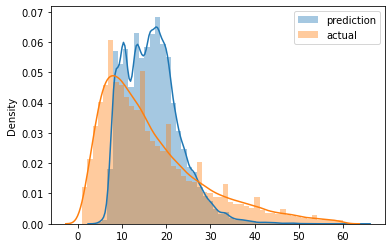

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
#lr = LinearRegression()
#lr.fit(X_train, y_train)

#y_pred = lr.predict(X_val)

#mean_squared_error(y_val, y_pred, squared=False)

In [44]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

# Model - Experiment Tracking with MLflow

In [19]:
with mlflow.start_run(run_name="test_run") as run:
    
    mlflow.set_tag("developer", "frauke")
    
    mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "../data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

# Second Model - with Hyperparameter Tuning

In [20]:
!pip install hyperopt

In [21]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [32]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        # log paramters in mlflow
        mlflow.log_params(params)
        booster = xgb.train(
            # paramters are passed to xgboost
            params=params,
            # training on train data
            dtrain=train,
            # set boosting rounds
            num_boost_round=1000,
            # validation is done on validation dataset
            evals=[(valid, 'validation')],
            # if model does not improve for 50 methods->stop
            early_stopping_rounds=50
        )
        # make predictions
        y_pred = booster.predict(valid)
        # calculate error
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        # log metric
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [24]:
# define the search space, i.e. the range of parameters for hyperparamter tuning
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), #[exp(-3), exp(0)] = [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

# fmin method tries to minimize the metric
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[07:34:43] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:11.88406                          
[1]	validation-rmse:8.34894                           
[2]	validation-rmse:7.15370                           
[3]	validation-rmse:6.76281                           
[4]	validation-rmse:6.61252                           
[5]	validation-rmse:6.55055                           
[6]	validation-rmse:6.52497                           
[7]	validation-rmse:6.50495                           
[8]	validation-rmse:6.49755                           
[9]	validation-rmse:6.49210                           
[10]	validation-rmse:6.48548                          
[11]	validation-rmse:6.47870                          
[12]	validation-rmse:6.47271                          
[13]	validation-rmse:6.46799                          
[14]	validation-rmse:6.46483                          
[15]	validation-rmse:6.46242                          
[

[23]	validation-rmse:6.43759                                                   
[24]	validation-rmse:6.43806                                                   
[25]	validation-rmse:6.43638                                                   
[26]	validation-rmse:6.43461                                                   
[27]	validation-rmse:6.43341                                                   
[28]	validation-rmse:6.43360                                                   
[29]	validation-rmse:6.43226                                                   
[30]	validation-rmse:6.43025                                                   
[31]	validation-rmse:6.42774                                                   
[32]	validation-rmse:6.42660                                                   
[33]	validation-rmse:6.42640                                                   
[34]	validation-rmse:6.42548                                                   
[35]	validation-rmse:6.42579            

[6]	validation-rmse:12.17640                                                   
[7]	validation-rmse:11.41996                                                   
[8]	validation-rmse:10.75923                                                   
[9]	validation-rmse:10.18611                                                   
[10]	validation-rmse:9.68352                                                   
[11]	validation-rmse:9.24554                                                   
[12]	validation-rmse:8.86824                                                   
[13]	validation-rmse:8.54060                                                   
[14]	validation-rmse:8.26069                                                   
[15]	validation-rmse:8.01579                                                   
[16]	validation-rmse:7.80701                                                   
[17]	validation-rmse:7.62485                                                   
[18]	validation-rmse:7.47039            

[108]	validation-rmse:6.39495                                                  
[109]	validation-rmse:6.39462                                                  
[110]	validation-rmse:6.39413                                                  
[111]	validation-rmse:6.39360                                                  
[112]	validation-rmse:6.39317                                                  
[113]	validation-rmse:6.39265                                                  
[114]	validation-rmse:6.39211                                                  
[115]	validation-rmse:6.39142                                                  
[116]	validation-rmse:6.39070                                                  
[117]	validation-rmse:6.39024                                                  
[118]	validation-rmse:6.38971                                                  
[119]	validation-rmse:6.38896                                                  
[120]	validation-rmse:6.38850           

[210]	validation-rmse:6.35790                                                  
[211]	validation-rmse:6.35757                                                  
[212]	validation-rmse:6.35747                                                  
[213]	validation-rmse:6.35728                                                  
[214]	validation-rmse:6.35681                                                  
[215]	validation-rmse:6.35653                                                  
[216]	validation-rmse:6.35617                                                  
[217]	validation-rmse:6.35606                                                  
[218]	validation-rmse:6.35604                                                  
[219]	validation-rmse:6.35590                                                  
[220]	validation-rmse:6.35541                                                  
[221]	validation-rmse:6.35518                                                  
[222]	validation-rmse:6.35459           

[312]	validation-rmse:6.33753                                                  
[313]	validation-rmse:6.33731                                                  
[314]	validation-rmse:6.33690                                                  
[315]	validation-rmse:6.33680                                                  
[316]	validation-rmse:6.33672                                                  
[317]	validation-rmse:6.33655                                                  
[318]	validation-rmse:6.33652                                                  
[319]	validation-rmse:6.33637                                                  
[320]	validation-rmse:6.33633                                                  
[321]	validation-rmse:6.33619                                                  
[322]	validation-rmse:6.33602                                                  
[323]	validation-rmse:6.33583                                                  
[324]	validation-rmse:6.33582           

[414]	validation-rmse:6.32627                                                  
[415]	validation-rmse:6.32612                                                  
[416]	validation-rmse:6.32599                                                  
[417]	validation-rmse:6.32601                                                  
[418]	validation-rmse:6.32590                                                  
[419]	validation-rmse:6.32573                                                  
[420]	validation-rmse:6.32571                                                  
[421]	validation-rmse:6.32567                                                  
[422]	validation-rmse:6.32564                                                  
[423]	validation-rmse:6.32578                                                  
[424]	validation-rmse:6.32561                                                  
[425]	validation-rmse:6.32597                                                  
[426]	validation-rmse:6.32595           

[516]	validation-rmse:6.32191                                                  
[517]	validation-rmse:6.32181                                                  
[518]	validation-rmse:6.32177                                                  
[519]	validation-rmse:6.32167                                                  
[520]	validation-rmse:6.32151                                                  
[521]	validation-rmse:6.32148                                                  
[522]	validation-rmse:6.32154                                                  
[523]	validation-rmse:6.32156                                                  
[524]	validation-rmse:6.32143                                                  
[525]	validation-rmse:6.32139                                                  
[526]	validation-rmse:6.32137                                                  
[527]	validation-rmse:6.32125                                                  
[528]	validation-rmse:6.32126           

[618]	validation-rmse:6.31921                                                  
[619]	validation-rmse:6.31959                                                  
[620]	validation-rmse:6.31968                                                  
[621]	validation-rmse:6.31965                                                  
[622]	validation-rmse:6.32000                                                  
[623]	validation-rmse:6.32000                                                  
[624]	validation-rmse:6.32000                                                  
[625]	validation-rmse:6.32010                                                  
[626]	validation-rmse:6.32005                                                  
[627]	validation-rmse:6.32005                                                  
[628]	validation-rmse:6.32002                                                  
[629]	validation-rmse:6.32001                                                  
[630]	validation-rmse:6.32018           

[50]	validation-rmse:6.86181                                                     
[51]	validation-rmse:6.84248                                                     
[52]	validation-rmse:6.82562                                                     
[53]	validation-rmse:6.80955                                                     
[54]	validation-rmse:6.79393                                                     
[55]	validation-rmse:6.78154                                                     
[56]	validation-rmse:6.76948                                                     
[57]	validation-rmse:6.75600                                                     
[58]	validation-rmse:6.74448                                                     
[59]	validation-rmse:6.73398                                                     
[60]	validation-rmse:6.72500                                                     
[61]	validation-rmse:6.71653                                                     
[62]	validation-

[149]	validation-rmse:6.55828                                                    
[150]	validation-rmse:6.55791                                                    
[151]	validation-rmse:6.55783                                                    
[152]	validation-rmse:6.55746                                                    
[153]	validation-rmse:6.55717                                                    
[154]	validation-rmse:6.55680                                                    
[155]	validation-rmse:6.55648                                                    
[156]	validation-rmse:6.55606                                                    
[157]	validation-rmse:6.55591                                                    
[158]	validation-rmse:6.55548                                                    
[159]	validation-rmse:6.55527                                                    
[160]	validation-rmse:6.55496                                                    
[161]	validation

[248]	validation-rmse:6.53752                                                    
[249]	validation-rmse:6.53738                                                    
[250]	validation-rmse:6.53720                                                    
[251]	validation-rmse:6.53699                                                    
[252]	validation-rmse:6.53685                                                    
[253]	validation-rmse:6.53682                                                    
[254]	validation-rmse:6.53668                                                    
[255]	validation-rmse:6.53660                                                    
[256]	validation-rmse:6.53656                                                    
[257]	validation-rmse:6.53633                                                    
[258]	validation-rmse:6.53619                                                    
[259]	validation-rmse:6.53599                                                    
[260]	validation

[347]	validation-rmse:6.52721                                                    
[348]	validation-rmse:6.52711                                                    
[349]	validation-rmse:6.52703                                                    
[350]	validation-rmse:6.52689                                                    
[351]	validation-rmse:6.52686                                                    
[352]	validation-rmse:6.52672                                                    
[353]	validation-rmse:6.52679                                                    
[354]	validation-rmse:6.52672                                                    
[355]	validation-rmse:6.52673                                                    
[356]	validation-rmse:6.52689                                                    
[357]	validation-rmse:6.52664                                                    
[358]	validation-rmse:6.52658                                                    
[359]	validation

[446]	validation-rmse:6.52082                                                    
[447]	validation-rmse:6.52090                                                    
[448]	validation-rmse:6.52081                                                    
[449]	validation-rmse:6.52084                                                    
[450]	validation-rmse:6.52076                                                    
[451]	validation-rmse:6.52094                                                    
[452]	validation-rmse:6.52079                                                    
[453]	validation-rmse:6.52084                                                    
[454]	validation-rmse:6.52067                                                    
[455]	validation-rmse:6.52058                                                    
[456]	validation-rmse:6.52055                                                    
[457]	validation-rmse:6.52043                                                    
[458]	validation

[545]	validation-rmse:6.51817                                                    
[546]	validation-rmse:6.51817                                                    
[547]	validation-rmse:6.51809                                                    
[548]	validation-rmse:6.51818                                                    
[549]	validation-rmse:6.51811                                                    
[550]	validation-rmse:6.51804                                                    
[551]	validation-rmse:6.51799                                                    
[552]	validation-rmse:6.51795                                                    
[553]	validation-rmse:6.51785                                                    
[554]	validation-rmse:6.51786                                                    
[555]	validation-rmse:6.51779                                                    
[556]	validation-rmse:6.51776                                                    
[557]	validation

[644]	validation-rmse:6.51681                                                    
[645]	validation-rmse:6.51682                                                    
[646]	validation-rmse:6.51680                                                    
[647]	validation-rmse:6.51677                                                    
[648]	validation-rmse:6.51663                                                    
[649]	validation-rmse:6.51656                                                    
[650]	validation-rmse:6.51670                                                    
[651]	validation-rmse:6.51668                                                    
[652]	validation-rmse:6.51661                                                    
[653]	validation-rmse:6.51650                                                    
[654]	validation-rmse:6.51647                                                    
[655]	validation-rmse:6.51644                                                    
[656]	validation

[13]	validation-rmse:6.58322                                                      
[14]	validation-rmse:6.57886                                                      
[15]	validation-rmse:6.57214                                                      
[16]	validation-rmse:6.56952                                                      
[17]	validation-rmse:6.56785                                                      
[18]	validation-rmse:6.56511                                                      
[19]	validation-rmse:6.56141                                                      
[20]	validation-rmse:6.55721                                                      
[21]	validation-rmse:6.55390                                                      
[22]	validation-rmse:6.55170                                                      
[23]	validation-rmse:6.54900                                                      
[24]	validation-rmse:6.54518                                                      
[25]

[111]	validation-rmse:6.41171                                                     
[112]	validation-rmse:6.41200                                                     
[113]	validation-rmse:6.41080                                                     
[114]	validation-rmse:6.41060                                                     
[115]	validation-rmse:6.40987                                                     
[116]	validation-rmse:6.40938                                                     
[117]	validation-rmse:6.40850                                                     
[118]	validation-rmse:6.40550                                                     
[119]	validation-rmse:6.40544                                                     
[120]	validation-rmse:6.40403                                                     
[121]	validation-rmse:6.40416                                                     
[122]	validation-rmse:6.40336                                                     
[123

[209]	validation-rmse:6.36869                                                     
[210]	validation-rmse:6.36613                                                     
[211]	validation-rmse:6.36600                                                     
[212]	validation-rmse:6.36652                                                     
[213]	validation-rmse:6.36643                                                     
[214]	validation-rmse:6.36604                                                     
[215]	validation-rmse:6.36631                                                     
[216]	validation-rmse:6.36640                                                     
[217]	validation-rmse:6.36672                                                     
[218]	validation-rmse:6.36692                                                     
[219]	validation-rmse:6.36642                                                     
[220]	validation-rmse:6.36619                                                     
[221

[45]	validation-rmse:6.62531                                                     
[46]	validation-rmse:6.61998                                                     
[47]	validation-rmse:6.61515                                                     
[48]	validation-rmse:6.61085                                                     
[49]	validation-rmse:6.60620                                                     
[50]	validation-rmse:6.60264                                                     
[51]	validation-rmse:6.59876                                                     
[52]	validation-rmse:6.59551                                                     
[53]	validation-rmse:6.59334                                                     
[54]	validation-rmse:6.59100                                                     
[55]	validation-rmse:6.58834                                                     
[56]	validation-rmse:6.58610                                                     
[57]	validation-

[144]	validation-rmse:6.53047                                                    
[145]	validation-rmse:6.53043                                                    
[146]	validation-rmse:6.53022                                                    
[147]	validation-rmse:6.52972                                                    
[148]	validation-rmse:6.52978                                                    
[149]	validation-rmse:6.52972                                                    
[150]	validation-rmse:6.52959                                                    
[151]	validation-rmse:6.52956                                                    
[152]	validation-rmse:6.52935                                                    
[153]	validation-rmse:6.52937                                                    
[154]	validation-rmse:6.52906                                                    
[155]	validation-rmse:6.52898                                                    
[156]	validation

[243]	validation-rmse:6.51608                                                    
[244]	validation-rmse:6.51599                                                    
[245]	validation-rmse:6.51574                                                    
[246]	validation-rmse:6.51617                                                    
[247]	validation-rmse:6.51560                                                    
[248]	validation-rmse:6.51581                                                    
[249]	validation-rmse:6.51579                                                    
[250]	validation-rmse:6.51581                                                    
[251]	validation-rmse:6.51576                                                    
[252]	validation-rmse:6.51572                                                    
[253]	validation-rmse:6.51545                                                    
[254]	validation-rmse:6.51545                                                    
[255]	validation

[342]	validation-rmse:6.51147                                                    
[343]	validation-rmse:6.51136                                                    
[344]	validation-rmse:6.51117                                                    
[345]	validation-rmse:6.51094                                                    
[346]	validation-rmse:6.51076                                                    
[347]	validation-rmse:6.51069                                                    
[348]	validation-rmse:6.51056                                                    
[349]	validation-rmse:6.51046                                                    
[350]	validation-rmse:6.51063                                                    
[351]	validation-rmse:6.51062                                                    
[352]	validation-rmse:6.51061                                                    
[353]	validation-rmse:6.51037                                                    
[354]	validation

[07:44:09] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.07807                                                      
[1]	validation-rmse:17.23875                                                      
[2]	validation-rmse:15.64307                                                      
[3]	validation-rmse:14.26510                                                      
[4]	validation-rmse:13.07855                                                      
[5]	validation-rmse:12.06126                                                      
[6]	validation-rmse:11.19224                                                      
[7]	validation-rmse:10.45253                                                      
[8]	validation-rmse:9.82580                                                       
[9]	validation-rmse:9.29924                                                       
[10]	validation-rmse:8.85538                       

[97]	validation-rmse:6.49095                                                      
[98]	validation-rmse:6.49051                                                      
[99]	validation-rmse:6.48965                                                      
[100]	validation-rmse:6.48896                                                     
[101]	validation-rmse:6.48883                                                     
[102]	validation-rmse:6.48853                                                     
[103]	validation-rmse:6.48815                                                     
[104]	validation-rmse:6.48785                                                     
[105]	validation-rmse:6.48763                                                     
[106]	validation-rmse:6.48734                                                     
[107]	validation-rmse:6.48701                                                     
[108]	validation-rmse:6.48664                                                     
[109

[195]	validation-rmse:6.47111                                                     
[196]	validation-rmse:6.47098                                                     
[197]	validation-rmse:6.47080                                                     
[198]	validation-rmse:6.47037                                                     
[199]	validation-rmse:6.47025                                                     
[200]	validation-rmse:6.47017                                                     
[201]	validation-rmse:6.47010                                                     
[202]	validation-rmse:6.46996                                                     
[203]	validation-rmse:6.47010                                                     
[204]	validation-rmse:6.47000                                                     
[205]	validation-rmse:6.47007                                                     
[206]	validation-rmse:6.47004                                                     
[207

[293]	validation-rmse:6.46710                                                     
[294]	validation-rmse:6.46713                                                     
[295]	validation-rmse:6.46724                                                     
[296]	validation-rmse:6.46724                                                     
[297]	validation-rmse:6.46720                                                     
[298]	validation-rmse:6.46711                                                     
[299]	validation-rmse:6.46710                                                     
[300]	validation-rmse:6.46715                                                     
[301]	validation-rmse:6.46714                                                     
[302]	validation-rmse:6.46702                                                     
[303]	validation-rmse:6.46716                                                     
[304]	validation-rmse:6.46697                                                     
[305

[53]	validation-rmse:6.56375                                                      
[54]	validation-rmse:6.56214                                                      
[55]	validation-rmse:6.56077                                                      
[56]	validation-rmse:6.55943                                                      
[57]	validation-rmse:6.55861                                                      
[58]	validation-rmse:6.55743                                                      
[59]	validation-rmse:6.55642                                                      
[60]	validation-rmse:6.55520                                                      
[61]	validation-rmse:6.55393                                                      
[62]	validation-rmse:6.55325                                                      
[63]	validation-rmse:6.55251                                                      
[64]	validation-rmse:6.55140                                                      
[65]

[151]	validation-rmse:6.51822                                                     
[152]	validation-rmse:6.51825                                                     
[153]	validation-rmse:6.51806                                                     
[154]	validation-rmse:6.51802                                                     
[155]	validation-rmse:6.51791                                                     
[156]	validation-rmse:6.51752                                                     
[157]	validation-rmse:6.51766                                                     
[158]	validation-rmse:6.51675                                                     
[159]	validation-rmse:6.51654                                                     
[160]	validation-rmse:6.51628                                                     
[161]	validation-rmse:6.51598                                                     
[162]	validation-rmse:6.51573                                                     
[163

[249]	validation-rmse:6.50758                                                     
[250]	validation-rmse:6.50758                                                     
[251]	validation-rmse:6.50758                                                     
[252]	validation-rmse:6.50750                                                     
[253]	validation-rmse:6.50762                                                     
[254]	validation-rmse:6.50745                                                     
[255]	validation-rmse:6.50735                                                     
[256]	validation-rmse:6.50728                                                     
[257]	validation-rmse:6.50763                                                     
[258]	validation-rmse:6.50740                                                     
[259]	validation-rmse:6.50754                                                     
[260]	validation-rmse:6.50789                                                     
[261

[17]	validation-rmse:7.47949                                                      
[18]	validation-rmse:7.35405                                                      
[19]	validation-rmse:7.24529                                                      
[20]	validation-rmse:7.15213                                                      
[21]	validation-rmse:7.07169                                                      
[22]	validation-rmse:6.99983                                                      
[23]	validation-rmse:6.94214                                                      
[24]	validation-rmse:6.88888                                                      
[25]	validation-rmse:6.84710                                                      
[26]	validation-rmse:6.81008                                                      
[27]	validation-rmse:6.77808                                                      
[28]	validation-rmse:6.74956                                                      
[29]

[115]	validation-rmse:6.49536                                                     
[116]	validation-rmse:6.49502                                                     
[117]	validation-rmse:6.49441                                                     
[118]	validation-rmse:6.49422                                                     
[119]	validation-rmse:6.49341                                                     
[120]	validation-rmse:6.49292                                                     
[121]	validation-rmse:6.49256                                                     
[122]	validation-rmse:6.49222                                                     
[123]	validation-rmse:6.49180                                                     
[124]	validation-rmse:6.49129                                                     
[125]	validation-rmse:6.49087                                                     
[126]	validation-rmse:6.49051                                                     
[127

[213]	validation-rmse:6.46556                                                     
[214]	validation-rmse:6.46534                                                     
[215]	validation-rmse:6.46505                                                     
[216]	validation-rmse:6.46498                                                     
[217]	validation-rmse:6.46460                                                     
[218]	validation-rmse:6.46433                                                     
[219]	validation-rmse:6.46455                                                     
[220]	validation-rmse:6.46426                                                     
[221]	validation-rmse:6.46420                                                     
[222]	validation-rmse:6.46362                                                     
[223]	validation-rmse:6.46326                                                     
[224]	validation-rmse:6.46354                                                     
[225

[311]	validation-rmse:6.44943                                                     
[312]	validation-rmse:6.44928                                                     
[313]	validation-rmse:6.44915                                                     
[314]	validation-rmse:6.44909                                                     
[315]	validation-rmse:6.44901                                                     
[316]	validation-rmse:6.44904                                                     
[317]	validation-rmse:6.44880                                                     
[318]	validation-rmse:6.44845                                                     
[319]	validation-rmse:6.44794                                                     
[320]	validation-rmse:6.44784                                                     
[321]	validation-rmse:6.44764                                                     
[322]	validation-rmse:6.44762                                                     
[323

[409]	validation-rmse:6.44053                                                     
[410]	validation-rmse:6.44057                                                     
[411]	validation-rmse:6.44026                                                     
[412]	validation-rmse:6.44013                                                     
[413]	validation-rmse:6.43997                                                     
[414]	validation-rmse:6.44006                                                     
[415]	validation-rmse:6.43985                                                     
[416]	validation-rmse:6.43977                                                     
[417]	validation-rmse:6.43996                                                     
[418]	validation-rmse:6.43990                                                     
[419]	validation-rmse:6.43978                                                     
[420]	validation-rmse:6.43979                                                     
[421

[507]	validation-rmse:6.43682                                                     
[508]	validation-rmse:6.43699                                                     
[509]	validation-rmse:6.43698                                                     
[510]	validation-rmse:6.43677                                                     
[511]	validation-rmse:6.43687                                                     
[512]	validation-rmse:6.43692                                                     
[513]	validation-rmse:6.43684                                                     
[514]	validation-rmse:6.43673                                                     
[515]	validation-rmse:6.43690                                                     
[516]	validation-rmse:6.43699                                                     
[517]	validation-rmse:6.43700                                                     
[518]	validation-rmse:6.43677                                                     
[519

[81]	validation-rmse:6.74383                                                      
[82]	validation-rmse:6.74119                                                      
[83]	validation-rmse:6.73861                                                      
[84]	validation-rmse:6.73654                                                      
[85]	validation-rmse:6.73449                                                      
[86]	validation-rmse:6.73273                                                      
[87]	validation-rmse:6.73114                                                      
[88]	validation-rmse:6.72962                                                      
[89]	validation-rmse:6.72812                                                      
[90]	validation-rmse:6.72697                                                      
[91]	validation-rmse:6.72577                                                      
[92]	validation-rmse:6.72415                                                      
[93]

[179]	validation-rmse:6.69647                                                     
[180]	validation-rmse:6.69633                                                     
[181]	validation-rmse:6.69615                                                     
[182]	validation-rmse:6.69590                                                     
[183]	validation-rmse:6.69583                                                     
[184]	validation-rmse:6.69566                                                     
[185]	validation-rmse:6.69566                                                     
[186]	validation-rmse:6.69567                                                     
[187]	validation-rmse:6.69555                                                     
[188]	validation-rmse:6.69545                                                     
[189]	validation-rmse:6.69542                                                     
[190]	validation-rmse:6.69533                                                     
[191

[277]	validation-rmse:6.69325                                                     
[278]	validation-rmse:6.69320                                                     
[279]	validation-rmse:6.69318                                                     
[280]	validation-rmse:6.69319                                                     
[281]	validation-rmse:6.69330                                                     
[282]	validation-rmse:6.69335                                                     
[283]	validation-rmse:6.69337                                                     
[284]	validation-rmse:6.69341                                                     
[285]	validation-rmse:6.69340                                                     
[286]	validation-rmse:6.69340                                                     
[287]	validation-rmse:6.69335                                                     
[288]	validation-rmse:6.69333                                                     
[289

[55]	validation-rmse:6.72248                                                       
[56]	validation-rmse:6.71968                                                       
[57]	validation-rmse:6.71728                                                       
[58]	validation-rmse:6.71424                                                       
[59]	validation-rmse:6.71163                                                       
[60]	validation-rmse:6.70918                                                       
[61]	validation-rmse:6.70742                                                       
[62]	validation-rmse:6.70543                                                       
[63]	validation-rmse:6.70355                                                       
[64]	validation-rmse:6.70208                                                       
[65]	validation-rmse:6.70036                                                       
[66]	validation-rmse:6.69875                                                

[152]	validation-rmse:6.67192                                                      
[153]	validation-rmse:6.67184                                                      
[154]	validation-rmse:6.67179                                                      
[155]	validation-rmse:6.67180                                                      
[156]	validation-rmse:6.67178                                                      
[157]	validation-rmse:6.67178                                                      
[158]	validation-rmse:6.67174                                                      
[159]	validation-rmse:6.67168                                                      
[160]	validation-rmse:6.67165                                                      
[161]	validation-rmse:6.67163                                                      
[162]	validation-rmse:6.67155                                                      
[163]	validation-rmse:6.67150                                               

[249]	validation-rmse:6.66977                                                      
[250]	validation-rmse:6.66979                                                      
[251]	validation-rmse:6.66990                                                      
[252]	validation-rmse:6.66979                                                      
[253]	validation-rmse:6.66980                                                      
[254]	validation-rmse:6.66963                                                      
[255]	validation-rmse:6.66955                                                      
[256]	validation-rmse:6.66961                                                      
[257]	validation-rmse:6.66970                                                      
[258]	validation-rmse:6.66952                                                      
[259]	validation-rmse:6.66953                                                      
[260]	validation-rmse:6.66951                                               

[346]	validation-rmse:6.66813                                                      
[347]	validation-rmse:6.66812                                                      
[348]	validation-rmse:6.66790                                                      
[349]	validation-rmse:6.66796                                                      
[350]	validation-rmse:6.66800                                                      
[351]	validation-rmse:6.66829                                                      
[352]	validation-rmse:6.66829                                                      
[353]	validation-rmse:6.66820                                                      
[354]	validation-rmse:6.66804                                                      
[355]	validation-rmse:6.66800                                                      
[356]	validation-rmse:6.66808                                                      
[357]	validation-rmse:6.66783                                               

[443]	validation-rmse:6.66636                                                      
[444]	validation-rmse:6.66642                                                      
[445]	validation-rmse:6.66634                                                      
[446]	validation-rmse:6.66636                                                      
[447]	validation-rmse:6.66628                                                      
[448]	validation-rmse:6.66631                                                      
[449]	validation-rmse:6.66626                                                      
[450]	validation-rmse:6.66628                                                      
[451]	validation-rmse:6.66635                                                      
[452]	validation-rmse:6.66633                                                      
[453]	validation-rmse:6.66634                                                      
[454]	validation-rmse:6.66626                                               

[16]	validation-rmse:6.54274                                                       
[17]	validation-rmse:6.53791                                                       
[18]	validation-rmse:6.53539                                                       
[19]	validation-rmse:6.53340                                                       
[20]	validation-rmse:6.53176                                                       
[21]	validation-rmse:6.53017                                                       
[22]	validation-rmse:6.52843                                                       
[23]	validation-rmse:6.52648                                                       
[24]	validation-rmse:6.52312                                                       
[25]	validation-rmse:6.52076                                                       
[26]	validation-rmse:6.51701                                                       
[27]	validation-rmse:6.51511                                                

[113]	validation-rmse:6.45358                                                      
[114]	validation-rmse:6.45404                                                      
[115]	validation-rmse:6.45434                                                      
[116]	validation-rmse:6.45365                                                      
[117]	validation-rmse:6.45265                                                      
[118]	validation-rmse:6.45254                                                      
[119]	validation-rmse:6.45234                                                      
[120]	validation-rmse:6.45218                                                      
[121]	validation-rmse:6.45289                                                      
[122]	validation-rmse:6.45213                                                      
[123]	validation-rmse:6.45290                                                      
[124]	validation-rmse:6.45296                                               

[210]	validation-rmse:6.45631                                                      
[211]	validation-rmse:6.45606                                                      
[212]	validation-rmse:6.45633                                                      
[213]	validation-rmse:6.45553                                                      
[214]	validation-rmse:6.45573                                                      
[215]	validation-rmse:6.45580                                                      
[216]	validation-rmse:6.45580                                                      
[217]	validation-rmse:6.45720                                                      
[218]	validation-rmse:6.45719                                                      
[219]	validation-rmse:6.45716                                                      
[220]	validation-rmse:6.45776                                                      
[221]	validation-rmse:6.45745                                               

[85]	validation-rmse:6.48036                                                    
[86]	validation-rmse:6.48088                                                    
[07:54:33] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.77803                                                    
[1]	validation-rmse:18.48825                                                    
[2]	validation-rmse:17.31255                                                    
[3]	validation-rmse:16.24377                                                    
[4]	validation-rmse:15.27083                                                    
[5]	validation-rmse:14.38788                                                    
[6]	validation-rmse:13.58427                                                    
[7]	validation-rmse:12.85993                                                    
[8]	validation-rmse:12.20220                                           

[97]	validation-rmse:6.52500                                                    
[98]	validation-rmse:6.52448                                                    
[99]	validation-rmse:6.52385                                                    
[100]	validation-rmse:6.52337                                                   
[101]	validation-rmse:6.52297                                                   
[102]	validation-rmse:6.52233                                                   
[103]	validation-rmse:6.52188                                                   
[104]	validation-rmse:6.52126                                                   
[105]	validation-rmse:6.52078                                                   
[106]	validation-rmse:6.52025                                                   
[107]	validation-rmse:6.51990                                                   
[108]	validation-rmse:6.51933                                                   
[109]	validation-rmse:6.5186

[198]	validation-rmse:6.48456                                                   
[199]	validation-rmse:6.48436                                                   
[200]	validation-rmse:6.48366                                                   
[201]	validation-rmse:6.48328                                                   
[202]	validation-rmse:6.48316                                                   
[203]	validation-rmse:6.48283                                                   
[204]	validation-rmse:6.48245                                                   
[205]	validation-rmse:6.48232                                                   
[206]	validation-rmse:6.48212                                                   
[207]	validation-rmse:6.48167                                                   
[208]	validation-rmse:6.48143                                                   
[209]	validation-rmse:6.48072                                                   
[210]	validation-rmse:6.4803

[299]	validation-rmse:6.46015                                                   
[300]	validation-rmse:6.46006                                                   
[301]	validation-rmse:6.46006                                                   
[302]	validation-rmse:6.45988                                                   
[303]	validation-rmse:6.45971                                                   
[304]	validation-rmse:6.45943                                                   
[305]	validation-rmse:6.45937                                                   
[306]	validation-rmse:6.45920                                                   
[307]	validation-rmse:6.45922                                                   
[308]	validation-rmse:6.45915                                                   
[309]	validation-rmse:6.45898                                                   
[310]	validation-rmse:6.45864                                                   
[311]	validation-rmse:6.4582

[400]	validation-rmse:6.44531                                                   
[401]	validation-rmse:6.44520                                                   
[402]	validation-rmse:6.44513                                                   
[403]	validation-rmse:6.44481                                                   
[404]	validation-rmse:6.44467                                                   
[405]	validation-rmse:6.44448                                                   
[406]	validation-rmse:6.44425                                                   
[407]	validation-rmse:6.44411                                                   
[408]	validation-rmse:6.44406                                                   
[409]	validation-rmse:6.44401                                                   
[410]	validation-rmse:6.44398                                                   
[411]	validation-rmse:6.44386                                                   
[412]	validation-rmse:6.4439

[501]	validation-rmse:6.43381                                                   
[502]	validation-rmse:6.43367                                                   
[503]	validation-rmse:6.43358                                                   
[504]	validation-rmse:6.43343                                                   
[505]	validation-rmse:6.43334                                                   
[506]	validation-rmse:6.43314                                                   
[507]	validation-rmse:6.43308                                                   
[508]	validation-rmse:6.43296                                                   
[509]	validation-rmse:6.43278                                                   
[510]	validation-rmse:6.43298                                                   
[511]	validation-rmse:6.43252                                                   
[512]	validation-rmse:6.43275                                                   
[513]	validation-rmse:6.4326

[602]	validation-rmse:6.42593                                                   
[603]	validation-rmse:6.42596                                                   
[604]	validation-rmse:6.42589                                                   
[605]	validation-rmse:6.42580                                                   
[606]	validation-rmse:6.42579                                                   
[607]	validation-rmse:6.42562                                                   
[608]	validation-rmse:6.42550                                                   
[609]	validation-rmse:6.42533                                                   
[610]	validation-rmse:6.42528                                                   
[611]	validation-rmse:6.42540                                                   
[612]	validation-rmse:6.42529                                                   
[613]	validation-rmse:6.42519                                                   
[614]	validation-rmse:6.4251

[703]	validation-rmse:6.41990                                                   
[704]	validation-rmse:6.41987                                                   
[705]	validation-rmse:6.41978                                                   
[706]	validation-rmse:6.41979                                                   
[707]	validation-rmse:6.41969                                                   
[708]	validation-rmse:6.41973                                                   
[709]	validation-rmse:6.41975                                                   
[710]	validation-rmse:6.41968                                                   
[711]	validation-rmse:6.41977                                                   
[712]	validation-rmse:6.41983                                                   
[713]	validation-rmse:6.41987                                                   
[714]	validation-rmse:6.41979                                                   
[715]	validation-rmse:6.4198

[804]	validation-rmse:6.41604                                                   
[805]	validation-rmse:6.41608                                                   
[806]	validation-rmse:6.41609                                                   
[807]	validation-rmse:6.41602                                                   
[808]	validation-rmse:6.41599                                                   
[809]	validation-rmse:6.41591                                                   
[810]	validation-rmse:6.41588                                                   
[811]	validation-rmse:6.41596                                                   
[812]	validation-rmse:6.41591                                                   
[813]	validation-rmse:6.41580                                                   
[814]	validation-rmse:6.41566                                                   
[815]	validation-rmse:6.41559                                                   
[816]	validation-rmse:6.4156

[905]	validation-rmse:6.41336                                                   
[906]	validation-rmse:6.41323                                                   
[907]	validation-rmse:6.41316                                                   
[908]	validation-rmse:6.41324                                                   
[909]	validation-rmse:6.41325                                                   
[910]	validation-rmse:6.41322                                                   
[911]	validation-rmse:6.41316                                                   
[912]	validation-rmse:6.41310                                                   
[913]	validation-rmse:6.41311                                                   
[914]	validation-rmse:6.41312                                                   
[915]	validation-rmse:6.41303                                                   
[916]	validation-rmse:6.41296                                                   
[917]	validation-rmse:6.4129

[4]	validation-rmse:7.99210                                                     
[5]	validation-rmse:7.44256                                                     
[6]	validation-rmse:7.10300                                                     
[7]	validation-rmse:6.89649                                                     
[8]	validation-rmse:6.76851                                                     
[9]	validation-rmse:6.68902                                                     
[10]	validation-rmse:6.63000                                                    
[11]	validation-rmse:6.59637                                                    
[12]	validation-rmse:6.56886                                                    
[13]	validation-rmse:6.54874                                                    
[14]	validation-rmse:6.53321                                                    
[15]	validation-rmse:6.52256                                                    
[16]	validation-rmse:6.51275

[105]	validation-rmse:6.41536                                                   
[106]	validation-rmse:6.41535                                                   
[107]	validation-rmse:6.41551                                                   
[108]	validation-rmse:6.41527                                                   
[109]	validation-rmse:6.41474                                                   
[110]	validation-rmse:6.41419                                                   
[111]	validation-rmse:6.41510                                                   
[112]	validation-rmse:6.41528                                                   
[113]	validation-rmse:6.41485                                                   
[114]	validation-rmse:6.41419                                                   
[115]	validation-rmse:6.41343                                                   
[116]	validation-rmse:6.41382                                                   
[117]	validation-rmse:6.4133

[206]	validation-rmse:6.41226                                                   
[207]	validation-rmse:6.41215                                                   
[208]	validation-rmse:6.41237                                                   
[209]	validation-rmse:6.41227                                                   
[210]	validation-rmse:6.41235                                                   
[211]	validation-rmse:6.41232                                                   
[212]	validation-rmse:6.41258                                                   
[213]	validation-rmse:6.41274                                                   
[214]	validation-rmse:6.41287                                                   
[215]	validation-rmse:6.41305                                                   
[216]	validation-rmse:6.41299                                                   
[217]	validation-rmse:6.41297                                                   
[218]	validation-rmse:6.4130

[69]	validation-rmse:6.58158                                                    
[70]	validation-rmse:6.57871                                                    
[71]	validation-rmse:6.57618                                                    
[72]	validation-rmse:6.57375                                                    
[73]	validation-rmse:6.57188                                                    
[74]	validation-rmse:6.56977                                                    
[75]	validation-rmse:6.56774                                                    
[76]	validation-rmse:6.56549                                                    
[77]	validation-rmse:6.56403                                                    
[78]	validation-rmse:6.56235                                                    
[79]	validation-rmse:6.56079                                                    
[80]	validation-rmse:6.55937                                                    
[81]	validation-rmse:6.55750

[170]	validation-rmse:6.50583                                                   
[171]	validation-rmse:6.50554                                                   
[172]	validation-rmse:6.50512                                                   
[173]	validation-rmse:6.50467                                                   
[174]	validation-rmse:6.50431                                                   
[175]	validation-rmse:6.50393                                                   
[176]	validation-rmse:6.50361                                                   
[177]	validation-rmse:6.50317                                                   
[178]	validation-rmse:6.50270                                                   
[179]	validation-rmse:6.50238                                                   
[180]	validation-rmse:6.50225                                                   
[181]	validation-rmse:6.50184                                                   
[182]	validation-rmse:6.5015

[271]	validation-rmse:6.47723                                                   
[272]	validation-rmse:6.47708                                                   
[273]	validation-rmse:6.47690                                                   
[274]	validation-rmse:6.47678                                                   
[275]	validation-rmse:6.47638                                                   
[276]	validation-rmse:6.47621                                                   
[277]	validation-rmse:6.47593                                                   
[278]	validation-rmse:6.47574                                                   
[279]	validation-rmse:6.47538                                                   
[280]	validation-rmse:6.47537                                                   
[281]	validation-rmse:6.47507                                                   
[282]	validation-rmse:6.47464                                                   
[283]	validation-rmse:6.4744

[372]	validation-rmse:6.45798                                                   
[373]	validation-rmse:6.45784                                                   
[374]	validation-rmse:6.45758                                                   
[375]	validation-rmse:6.45747                                                   
[376]	validation-rmse:6.45721                                                   
[377]	validation-rmse:6.45702                                                   
[378]	validation-rmse:6.45676                                                   
[379]	validation-rmse:6.45651                                                   
[380]	validation-rmse:6.45617                                                   
[381]	validation-rmse:6.45601                                                   
[382]	validation-rmse:6.45618                                                   
[383]	validation-rmse:6.45611                                                   
[384]	validation-rmse:6.4558

[473]	validation-rmse:6.44501                                                   
[474]	validation-rmse:6.44469                                                   
[475]	validation-rmse:6.44456                                                   
[476]	validation-rmse:6.44461                                                   
[477]	validation-rmse:6.44445                                                   
[478]	validation-rmse:6.44452                                                   
[479]	validation-rmse:6.44440                                                   
[480]	validation-rmse:6.44414                                                   
[481]	validation-rmse:6.44397                                                   
[482]	validation-rmse:6.44385                                                   
[483]	validation-rmse:6.44374                                                   
[484]	validation-rmse:6.44368                                                   
[485]	validation-rmse:6.4435

[574]	validation-rmse:6.43553                                                   
[575]	validation-rmse:6.43549                                                   
[576]	validation-rmse:6.43551                                                   
[577]	validation-rmse:6.43532                                                   
[578]	validation-rmse:6.43513                                                   
[579]	validation-rmse:6.43525                                                   
[580]	validation-rmse:6.43516                                                   
[581]	validation-rmse:6.43494                                                   
[582]	validation-rmse:6.43477                                                   
[583]	validation-rmse:6.43477                                                   
[584]	validation-rmse:6.43464                                                   
[585]	validation-rmse:6.43449                                                   
[586]	validation-rmse:6.4343

[675]	validation-rmse:6.42831                                                   
[676]	validation-rmse:6.42828                                                   
[677]	validation-rmse:6.42830                                                   
[678]	validation-rmse:6.42819                                                   
[679]	validation-rmse:6.42810                                                   
[680]	validation-rmse:6.42813                                                   
[681]	validation-rmse:6.42813                                                   
[682]	validation-rmse:6.42802                                                   
[683]	validation-rmse:6.42792                                                   
[684]	validation-rmse:6.42781                                                   
[685]	validation-rmse:6.42780                                                   
[686]	validation-rmse:6.42757                                                   
[687]	validation-rmse:6.4276

[776]	validation-rmse:6.42204                                                   
[777]	validation-rmse:6.42197                                                   
[778]	validation-rmse:6.42198                                                   
[779]	validation-rmse:6.42192                                                   
[780]	validation-rmse:6.42189                                                   
[781]	validation-rmse:6.42173                                                   
[782]	validation-rmse:6.42173                                                   
[783]	validation-rmse:6.42164                                                   
[784]	validation-rmse:6.42163                                                   
[785]	validation-rmse:6.42157                                                   
[786]	validation-rmse:6.42152                                                   
[787]	validation-rmse:6.42146                                                   
[788]	validation-rmse:6.4214

[877]	validation-rmse:6.41779                                                   
[878]	validation-rmse:6.41785                                                   
[879]	validation-rmse:6.41787                                                   
[880]	validation-rmse:6.41766                                                   
[881]	validation-rmse:6.41754                                                   
[882]	validation-rmse:6.41749                                                   
[883]	validation-rmse:6.41750                                                   
[884]	validation-rmse:6.41800                                                   
[885]	validation-rmse:6.41785                                                   
[886]	validation-rmse:6.41779                                                   
[887]	validation-rmse:6.41768                                                   
[888]	validation-rmse:6.41757                                                   
[889]	validation-rmse:6.4174

[978]	validation-rmse:6.41514                                                   
[979]	validation-rmse:6.41512                                                   
[980]	validation-rmse:6.41500                                                   
[981]	validation-rmse:6.41502                                                   
[982]	validation-rmse:6.41491                                                   
[983]	validation-rmse:6.41489                                                   
[984]	validation-rmse:6.41491                                                   
[985]	validation-rmse:6.41493                                                   
[986]	validation-rmse:6.41496                                                   
[987]	validation-rmse:6.41495                                                   
[988]	validation-rmse:6.41501                                                   
[989]	validation-rmse:6.41509                                                   
[990]	validation-rmse:6.4150

[76]	validation-rmse:6.44510                                                     
[77]	validation-rmse:6.44356                                                     
[78]	validation-rmse:6.44288                                                     
[79]	validation-rmse:6.44343                                                     
[80]	validation-rmse:6.44300                                                     
[81]	validation-rmse:6.44279                                                     
[82]	validation-rmse:6.44250                                                     
[83]	validation-rmse:6.44290                                                     
[84]	validation-rmse:6.44277                                                     
[85]	validation-rmse:6.44251                                                     
[86]	validation-rmse:6.44254                                                     
[87]	validation-rmse:6.44291                                                     
[88]	validation-

[175]	validation-rmse:6.43530                                                    
[176]	validation-rmse:6.43509                                                    
[177]	validation-rmse:6.43563                                                    
[178]	validation-rmse:6.43577                                                    
[179]	validation-rmse:6.43575                                                    
[180]	validation-rmse:6.43610                                                    
[181]	validation-rmse:6.43597                                                    
[182]	validation-rmse:6.43643                                                    
[183]	validation-rmse:6.43622                                                    
[184]	validation-rmse:6.43662                                                    
[185]	validation-rmse:6.43690                                                    
[186]	validation-rmse:6.43694                                                    
[187]	validation

[73]	validation-rmse:6.60970                                                    
[74]	validation-rmse:6.60826                                                    
[75]	validation-rmse:6.60637                                                    
[76]	validation-rmse:6.60707                                                    
[77]	validation-rmse:6.60717                                                    
[78]	validation-rmse:6.60634                                                    
[79]	validation-rmse:6.60632                                                    
[80]	validation-rmse:6.60640                                                    
[81]	validation-rmse:6.60663                                                    
[82]	validation-rmse:6.61057                                                    
[83]	validation-rmse:6.61120                                                    
[84]	validation-rmse:6.61229                                                    
[85]	validation-rmse:6.61278

[74]	validation-rmse:6.41737                                                    
[75]	validation-rmse:6.41674                                                    
[76]	validation-rmse:6.41605                                                    
[77]	validation-rmse:6.41632                                                    
[78]	validation-rmse:6.41433                                                    
[79]	validation-rmse:6.41390                                                    
[80]	validation-rmse:6.41421                                                    
[81]	validation-rmse:6.41464                                                    
[82]	validation-rmse:6.41401                                                    
[83]	validation-rmse:6.41275                                                    
[84]	validation-rmse:6.41473                                                    
[85]	validation-rmse:6.41560                                                    
[86]	validation-rmse:6.41427

[23]	validation-rmse:6.70266                                                    
[24]	validation-rmse:6.70103                                                    
[25]	validation-rmse:6.69883                                                    
[26]	validation-rmse:6.69768                                                    
[27]	validation-rmse:6.69615                                                    
[28]	validation-rmse:6.69556                                                    
[29]	validation-rmse:6.69451                                                    
[30]	validation-rmse:6.69400                                                    
[31]	validation-rmse:6.69356                                                    
[32]	validation-rmse:6.69301                                                    
[33]	validation-rmse:6.69285                                                    
[34]	validation-rmse:6.69183                                                    
[35]	validation-rmse:6.69202

[0]	validation-rmse:18.32612                                                    
[1]	validation-rmse:15.97415                                                    
[2]	validation-rmse:14.05423                                                    
[3]	validation-rmse:12.50119                                                    
[4]	validation-rmse:11.25281                                                    
[5]	validation-rmse:10.25851                                                    
[6]	validation-rmse:9.47373                                                     
[7]	validation-rmse:8.85672                                                     
[8]	validation-rmse:8.37564                                                     
[9]	validation-rmse:8.00103                                                     
[10]	validation-rmse:7.71248                                                    
[11]	validation-rmse:7.48827                                                    
[12]	validation-rmse:7.31570

[101]	validation-rmse:6.59161                                                   
[102]	validation-rmse:6.59094                                                   
[103]	validation-rmse:6.59031                                                   
[104]	validation-rmse:6.58883                                                   
[105]	validation-rmse:6.58814                                                   
[106]	validation-rmse:6.58761                                                   
[107]	validation-rmse:6.58678                                                   
[108]	validation-rmse:6.58590                                                   
[109]	validation-rmse:6.58556                                                   
[110]	validation-rmse:6.58491                                                   
[111]	validation-rmse:6.58432                                                   
[112]	validation-rmse:6.58382                                                   
[113]	validation-rmse:6.5834

[202]	validation-rmse:6.54586                                                   
[203]	validation-rmse:6.54551                                                   
[204]	validation-rmse:6.54519                                                   
[205]	validation-rmse:6.54474                                                   
[206]	validation-rmse:6.54371                                                   
[207]	validation-rmse:6.54321                                                   
[208]	validation-rmse:6.54300                                                   
[209]	validation-rmse:6.54282                                                   
[210]	validation-rmse:6.54253                                                   
[211]	validation-rmse:6.54201                                                   
[212]	validation-rmse:6.54170                                                   
[213]	validation-rmse:6.54157                                                   
[214]	validation-rmse:6.5411

[303]	validation-rmse:6.51587                                                   
[304]	validation-rmse:6.51554                                                   
[305]	validation-rmse:6.51530                                                   
[306]	validation-rmse:6.51525                                                   
[307]	validation-rmse:6.51516                                                   
[308]	validation-rmse:6.51497                                                   
[309]	validation-rmse:6.51458                                                   
[310]	validation-rmse:6.51444                                                   
[311]	validation-rmse:6.51427                                                   
[312]	validation-rmse:6.51391                                                   
[313]	validation-rmse:6.51366                                                   
[314]	validation-rmse:6.51363                                                   
[315]	validation-rmse:6.5136

[404]	validation-rmse:6.49597                                                   
[405]	validation-rmse:6.49560                                                   
[406]	validation-rmse:6.49546                                                   
[407]	validation-rmse:6.49533                                                   
[408]	validation-rmse:6.49526                                                   
[409]	validation-rmse:6.49512                                                   
[410]	validation-rmse:6.49498                                                   
[411]	validation-rmse:6.49502                                                   
[412]	validation-rmse:6.49490                                                   
[413]	validation-rmse:6.49477                                                   
[414]	validation-rmse:6.49466                                                   
[415]	validation-rmse:6.49442                                                   
[416]	validation-rmse:6.4943

[505]	validation-rmse:6.48193                                                   
[506]	validation-rmse:6.48182                                                   
[507]	validation-rmse:6.48171                                                   
[508]	validation-rmse:6.48167                                                   
[509]	validation-rmse:6.48155                                                   
[510]	validation-rmse:6.48097                                                   
[511]	validation-rmse:6.48096                                                   
[512]	validation-rmse:6.48083                                                   
[513]	validation-rmse:6.48067                                                   
[514]	validation-rmse:6.48048                                                   
[515]	validation-rmse:6.48038                                                   
[516]	validation-rmse:6.48029                                                   
[517]	validation-rmse:6.4802

[606]	validation-rmse:6.47068                                                   
[607]	validation-rmse:6.47058                                                   
[608]	validation-rmse:6.47042                                                   
[609]	validation-rmse:6.47030                                                   
[610]	validation-rmse:6.47020                                                   
[611]	validation-rmse:6.47010                                                   
[612]	validation-rmse:6.47009                                                   
[613]	validation-rmse:6.46976                                                   
[614]	validation-rmse:6.46967                                                   
[615]	validation-rmse:6.46951                                                   
[616]	validation-rmse:6.46949                                                   
[617]	validation-rmse:6.46926                                                   
[618]	validation-rmse:6.4693

[707]	validation-rmse:6.46267                                                   
[708]	validation-rmse:6.46260                                                   
[709]	validation-rmse:6.46247                                                   
[710]	validation-rmse:6.46203                                                   
[711]	validation-rmse:6.46229                                                   
[712]	validation-rmse:6.46232                                                   
[713]	validation-rmse:6.46238                                                   
[714]	validation-rmse:6.46232                                                   
[715]	validation-rmse:6.46220                                                   
[716]	validation-rmse:6.46215                                                   
[717]	validation-rmse:6.46209                                                   
[718]	validation-rmse:6.46204                                                   
[719]	validation-rmse:6.4619

[808]	validation-rmse:6.45564                                                   
[809]	validation-rmse:6.45568                                                   
[810]	validation-rmse:6.45560                                                   
[811]	validation-rmse:6.45561                                                   
[812]	validation-rmse:6.45545                                                   
[813]	validation-rmse:6.45538                                                   
[814]	validation-rmse:6.45528                                                   
[815]	validation-rmse:6.45532                                                   
[816]	validation-rmse:6.45523                                                   
[817]	validation-rmse:6.45533                                                   
[818]	validation-rmse:6.45530                                                   
[819]	validation-rmse:6.45529                                                   
[820]	validation-rmse:6.4551

[909]	validation-rmse:6.45028                                                   
[910]	validation-rmse:6.45023                                                   
[911]	validation-rmse:6.45019                                                   
[912]	validation-rmse:6.45014                                                   
[913]	validation-rmse:6.45019                                                   
[914]	validation-rmse:6.45014                                                   
[915]	validation-rmse:6.45012                                                   
[916]	validation-rmse:6.45008                                                   
[917]	validation-rmse:6.45037                                                   
[918]	validation-rmse:6.45034                                                   
[919]	validation-rmse:6.45000                                                   
[920]	validation-rmse:6.45008                                                   
[921]	validation-rmse:6.4496

[8]	validation-rmse:7.94333                                                     
[9]	validation-rmse:7.62016                                                     
[10]	validation-rmse:7.37882                                                    
[11]	validation-rmse:7.19643                                                    
[12]	validation-rmse:7.05828                                                    
[13]	validation-rmse:6.95263                                                    
[14]	validation-rmse:6.87318                                                    
[15]	validation-rmse:6.81097                                                    
[16]	validation-rmse:6.76236                                                    
[17]	validation-rmse:6.72309                                                    
[18]	validation-rmse:6.69096                                                    
[19]	validation-rmse:6.66545                                                    
[20]	validation-rmse:6.64561

[109]	validation-rmse:6.50193                                                   
[110]	validation-rmse:6.50160                                                   
[111]	validation-rmse:6.50138                                                   
[112]	validation-rmse:6.50115                                                   
[113]	validation-rmse:6.50081                                                   
[114]	validation-rmse:6.50078                                                   
[115]	validation-rmse:6.50074                                                   
[116]	validation-rmse:6.50077                                                   
[117]	validation-rmse:6.50054                                                   
[118]	validation-rmse:6.50039                                                   
[119]	validation-rmse:6.50007                                                   
[120]	validation-rmse:6.49988                                                   
[121]	validation-rmse:6.4996

[210]	validation-rmse:6.47839                                                   
[211]	validation-rmse:6.47768                                                   
[212]	validation-rmse:6.47767                                                   
[213]	validation-rmse:6.47765                                                   
[214]	validation-rmse:6.47757                                                   
[215]	validation-rmse:6.47748                                                   
[216]	validation-rmse:6.47739                                                   
[217]	validation-rmse:6.47727                                                   
[218]	validation-rmse:6.47719                                                   
[219]	validation-rmse:6.47714                                                   
[220]	validation-rmse:6.47719                                                   
[221]	validation-rmse:6.47713                                                   
[222]	validation-rmse:6.4769

[311]	validation-rmse:6.46966                                                   
[312]	validation-rmse:6.46978                                                   
[313]	validation-rmse:6.46973                                                   
[314]	validation-rmse:6.46982                                                   
[315]	validation-rmse:6.46958                                                   
[316]	validation-rmse:6.46947                                                   
[317]	validation-rmse:6.46952                                                   
[318]	validation-rmse:6.46948                                                   
[319]	validation-rmse:6.46950                                                   
[320]	validation-rmse:6.46939                                                   
[321]	validation-rmse:6.46948                                                   
[322]	validation-rmse:6.46937                                                   
[323]	validation-rmse:6.4693

[21]	validation-rmse:6.86012                                                    
[22]	validation-rmse:6.83886                                                    
[23]	validation-rmse:6.82299                                                    
[24]	validation-rmse:6.80752                                                    
[25]	validation-rmse:6.79580                                                    
[26]	validation-rmse:6.78349                                                    
[27]	validation-rmse:6.77627                                                    
[28]	validation-rmse:6.77020                                                    
[29]	validation-rmse:6.76175                                                    
[30]	validation-rmse:6.75675                                                    
[31]	validation-rmse:6.75230                                                    
[32]	validation-rmse:6.74893                                                    
[33]	validation-rmse:6.74527

[122]	validation-rmse:6.66454                                                   
[123]	validation-rmse:6.66435                                                   
[124]	validation-rmse:6.66371                                                   
[125]	validation-rmse:6.66320                                                   
[126]	validation-rmse:6.66282                                                   
[127]	validation-rmse:6.66199                                                   
[128]	validation-rmse:6.66126                                                   
[129]	validation-rmse:6.66077                                                   
[130]	validation-rmse:6.66046                                                   
[131]	validation-rmse:6.65990                                                   
[132]	validation-rmse:6.65896                                                   
[133]	validation-rmse:6.65873                                                   
[134]	validation-rmse:6.6584

[223]	validation-rmse:6.62077                                                   
[224]	validation-rmse:6.62059                                                   
[225]	validation-rmse:6.62023                                                   
[226]	validation-rmse:6.61995                                                   
[227]	validation-rmse:6.61956                                                   
[228]	validation-rmse:6.61951                                                   
[229]	validation-rmse:6.61889                                                   
[230]	validation-rmse:6.61826                                                   
[231]	validation-rmse:6.61789                                                   
[232]	validation-rmse:6.61786                                                   
[233]	validation-rmse:6.61732                                                   
[234]	validation-rmse:6.61708                                                   
[235]	validation-rmse:6.6168

[324]	validation-rmse:6.58771                                                   
[325]	validation-rmse:6.58748                                                   
[326]	validation-rmse:6.58722                                                   
[327]	validation-rmse:6.58714                                                   
[328]	validation-rmse:6.58667                                                   
[329]	validation-rmse:6.58641                                                   
[330]	validation-rmse:6.58638                                                   
[331]	validation-rmse:6.58606                                                   
[332]	validation-rmse:6.58556                                                   
[333]	validation-rmse:6.58523                                                   
[334]	validation-rmse:6.58493                                                   
[335]	validation-rmse:6.58460                                                   
[336]	validation-rmse:6.5844

[425]	validation-rmse:6.56000                                                   
[426]	validation-rmse:6.55966                                                   
[427]	validation-rmse:6.55955                                                   
[428]	validation-rmse:6.55940                                                   
[429]	validation-rmse:6.55939                                                   
[430]	validation-rmse:6.55901                                                   
[431]	validation-rmse:6.55886                                                   
[432]	validation-rmse:6.55865                                                   
[433]	validation-rmse:6.55833                                                   
[434]	validation-rmse:6.55806                                                   
[435]	validation-rmse:6.55783                                                   
[436]	validation-rmse:6.55785                                                   
[437]	validation-rmse:6.5577

[526]	validation-rmse:6.53781                                                   
[527]	validation-rmse:6.53755                                                   
[528]	validation-rmse:6.53731                                                   
[529]	validation-rmse:6.53728                                                   
[530]	validation-rmse:6.53691                                                   
[531]	validation-rmse:6.53653                                                   
[532]	validation-rmse:6.53647                                                   
[533]	validation-rmse:6.53621                                                   
[534]	validation-rmse:6.53606                                                   
[535]	validation-rmse:6.53588                                                   
[536]	validation-rmse:6.53589                                                   
[537]	validation-rmse:6.53572                                                   
[538]	validation-rmse:6.5352

[627]	validation-rmse:6.51792                                                   
[628]	validation-rmse:6.51802                                                   
[629]	validation-rmse:6.51779                                                   
[630]	validation-rmse:6.51763                                                   
[631]	validation-rmse:6.51759                                                   
[632]	validation-rmse:6.51734                                                   
[633]	validation-rmse:6.51748                                                   
[634]	validation-rmse:6.51701                                                   
[635]	validation-rmse:6.51676                                                   
[636]	validation-rmse:6.51659                                                   
[637]	validation-rmse:6.51636                                                   
[638]	validation-rmse:6.51605                                                   
[639]	validation-rmse:6.5157

[728]	validation-rmse:6.50070                                                   
[729]	validation-rmse:6.50050                                                   
[730]	validation-rmse:6.50047                                                   
[731]	validation-rmse:6.50042                                                   
[732]	validation-rmse:6.49991                                                   
[733]	validation-rmse:6.49984                                                   
[734]	validation-rmse:6.49954                                                   
[735]	validation-rmse:6.49934                                                   
[736]	validation-rmse:6.49938                                                   
[737]	validation-rmse:6.49922                                                   
[738]	validation-rmse:6.49885                                                   
[739]	validation-rmse:6.49868                                                   
[740]	validation-rmse:6.4985

[829]	validation-rmse:6.48586                                                   
[830]	validation-rmse:6.48555                                                   
[831]	validation-rmse:6.48558                                                   
[832]	validation-rmse:6.48539                                                   
[833]	validation-rmse:6.48510                                                   
[834]	validation-rmse:6.48512                                                   
[835]	validation-rmse:6.48487                                                   
[836]	validation-rmse:6.48483                                                   
[837]	validation-rmse:6.48479                                                   
[838]	validation-rmse:6.48463                                                   
[839]	validation-rmse:6.48460                                                   
[840]	validation-rmse:6.48437                                                   
[841]	validation-rmse:6.4843

[930]	validation-rmse:6.47059                                                   
[931]	validation-rmse:6.47051                                                   
[932]	validation-rmse:6.47048                                                   
[933]	validation-rmse:6.47041                                                   
[934]	validation-rmse:6.47037                                                   
[935]	validation-rmse:6.47037                                                   
[936]	validation-rmse:6.47011                                                   
[937]	validation-rmse:6.46962                                                   
[938]	validation-rmse:6.46958                                                   
[939]	validation-rmse:6.46963                                                   
[940]	validation-rmse:6.46963                                                   
[941]	validation-rmse:6.46940                                                   
[942]	validation-rmse:6.4693

[29]	validation-rmse:6.56733                                                    
[30]	validation-rmse:6.56491                                                    
[31]	validation-rmse:6.56279                                                    
[32]	validation-rmse:6.56007                                                    
[33]	validation-rmse:6.55818                                                    
[34]	validation-rmse:6.55653                                                    
[35]	validation-rmse:6.55486                                                    
[36]	validation-rmse:6.55300                                                    
[37]	validation-rmse:6.55026                                                    
[38]	validation-rmse:6.54924                                                    
[39]	validation-rmse:6.54769                                                    
[40]	validation-rmse:6.54608                                                    
[41]	validation-rmse:6.54452

[130]	validation-rmse:6.48341                                                   
[131]	validation-rmse:6.48273                                                   
[132]	validation-rmse:6.48251                                                   
[133]	validation-rmse:6.48211                                                   
[134]	validation-rmse:6.48176                                                   
[135]	validation-rmse:6.48162                                                   
[136]	validation-rmse:6.48115                                                   
[137]	validation-rmse:6.48067                                                   
[138]	validation-rmse:6.47999                                                   
[139]	validation-rmse:6.47947                                                   
[140]	validation-rmse:6.47912                                                   
[141]	validation-rmse:6.47870                                                   
[142]	validation-rmse:6.4783

[231]	validation-rmse:6.45552                                                   
[232]	validation-rmse:6.45542                                                   
[233]	validation-rmse:6.45529                                                   
[234]	validation-rmse:6.45513                                                   
[235]	validation-rmse:6.45502                                                   
[236]	validation-rmse:6.45492                                                   
[237]	validation-rmse:6.45468                                                   
[238]	validation-rmse:6.45466                                                   
[239]	validation-rmse:6.45448                                                   
[240]	validation-rmse:6.45427                                                   
[241]	validation-rmse:6.45365                                                   
[242]	validation-rmse:6.45339                                                   
[243]	validation-rmse:6.4532

[332]	validation-rmse:6.43978                                                   
[333]	validation-rmse:6.43968                                                   
[334]	validation-rmse:6.43965                                                   
[335]	validation-rmse:6.43899                                                   
[336]	validation-rmse:6.43804                                                   
[337]	validation-rmse:6.43769                                                   
[338]	validation-rmse:6.43707                                                   
[339]	validation-rmse:6.43669                                                   
[340]	validation-rmse:6.43663                                                   
[341]	validation-rmse:6.43658                                                   
[342]	validation-rmse:6.43664                                                   
[343]	validation-rmse:6.43661                                                   
[344]	validation-rmse:6.4365

[433]	validation-rmse:6.42654                                                   
[434]	validation-rmse:6.42661                                                   
[435]	validation-rmse:6.42661                                                   
[436]	validation-rmse:6.42652                                                   
[437]	validation-rmse:6.42655                                                   
[438]	validation-rmse:6.42644                                                   
[439]	validation-rmse:6.42639                                                   
[440]	validation-rmse:6.42630                                                   
[441]	validation-rmse:6.42619                                                   
[442]	validation-rmse:6.42619                                                   
[443]	validation-rmse:6.42622                                                   
[444]	validation-rmse:6.42605                                                   
[445]	validation-rmse:6.4259

[534]	validation-rmse:6.42283                                                   
[535]	validation-rmse:6.42286                                                   
[536]	validation-rmse:6.42274                                                   
[537]	validation-rmse:6.42269                                                   
[538]	validation-rmse:6.42261                                                   
[539]	validation-rmse:6.42272                                                   
[540]	validation-rmse:6.42276                                                   
[541]	validation-rmse:6.42266                                                   
[542]	validation-rmse:6.42256                                                   
[543]	validation-rmse:6.42263                                                   
[544]	validation-rmse:6.42270                                                   
[545]	validation-rmse:6.42272                                                   
[546]	validation-rmse:6.4228

[78]	validation-rmse:6.37897                                                    
[79]	validation-rmse:6.37903                                                    
[80]	validation-rmse:6.37820                                                    
[81]	validation-rmse:6.37903                                                    
[82]	validation-rmse:6.37637                                                    
[83]	validation-rmse:6.37593                                                    
[84]	validation-rmse:6.37370                                                    
[85]	validation-rmse:6.37233                                                    
[86]	validation-rmse:6.37433                                                    
[87]	validation-rmse:6.37781                                                    
[88]	validation-rmse:6.37626                                                    
[89]	validation-rmse:6.37505                                                    
[90]	validation-rmse:6.37531

[41]	validation-rmse:7.41129                                                    
[42]	validation-rmse:7.36100                                                    
[43]	validation-rmse:7.31412                                                    
[44]	validation-rmse:7.27036                                                    
[45]	validation-rmse:7.23004                                                    
[46]	validation-rmse:7.19250                                                    
[47]	validation-rmse:7.15764                                                    
[48]	validation-rmse:7.12513                                                    
[49]	validation-rmse:7.09505                                                    
[50]	validation-rmse:7.06704                                                    
[51]	validation-rmse:7.04093                                                    
[52]	validation-rmse:7.01659                                                    
[53]	validation-rmse:6.99356

[142]	validation-rmse:6.62606                                                   
[143]	validation-rmse:6.62579                                                   
[144]	validation-rmse:6.62554                                                   
[145]	validation-rmse:6.62522                                                   
[146]	validation-rmse:6.62496                                                   
[147]	validation-rmse:6.62461                                                   
[148]	validation-rmse:6.62442                                                   
[149]	validation-rmse:6.62413                                                   
[150]	validation-rmse:6.62386                                                   
[151]	validation-rmse:6.62367                                                   
[152]	validation-rmse:6.62343                                                   
[153]	validation-rmse:6.62322                                                   
[154]	validation-rmse:6.6229

[243]	validation-rmse:6.60827                                                   
[244]	validation-rmse:6.60817                                                   
[245]	validation-rmse:6.60801                                                   
[246]	validation-rmse:6.60793                                                   
[247]	validation-rmse:6.60782                                                   
[248]	validation-rmse:6.60773                                                   
[249]	validation-rmse:6.60762                                                   
[250]	validation-rmse:6.60750                                                   
[251]	validation-rmse:6.60735                                                   
[252]	validation-rmse:6.60725                                                   
[253]	validation-rmse:6.60708                                                   
[254]	validation-rmse:6.60696                                                   
[255]	validation-rmse:6.6067

[344]	validation-rmse:6.59718                                                   
[345]	validation-rmse:6.59714                                                   
[346]	validation-rmse:6.59707                                                   
[347]	validation-rmse:6.59695                                                   
[348]	validation-rmse:6.59676                                                   
[349]	validation-rmse:6.59668                                                   
[350]	validation-rmse:6.59669                                                   
[351]	validation-rmse:6.59661                                                   
[352]	validation-rmse:6.59654                                                   
[353]	validation-rmse:6.59643                                                   
[354]	validation-rmse:6.59637                                                   
[355]	validation-rmse:6.59629                                                   
[356]	validation-rmse:6.5962

[445]	validation-rmse:6.59131                                                   
[446]	validation-rmse:6.59129                                                   
[447]	validation-rmse:6.59123                                                   
[448]	validation-rmse:6.59117                                                   
[449]	validation-rmse:6.59115                                                   
[450]	validation-rmse:6.59110                                                   
[451]	validation-rmse:6.59101                                                   
[452]	validation-rmse:6.59097                                                   
[453]	validation-rmse:6.59094                                                   
[454]	validation-rmse:6.59091                                                   
[455]	validation-rmse:6.59087                                                   
[456]	validation-rmse:6.59084                                                   
[457]	validation-rmse:6.5908

[546]	validation-rmse:6.58778                                                   
[547]	validation-rmse:6.58777                                                   
[548]	validation-rmse:6.58775                                                   
[549]	validation-rmse:6.58767                                                   
[550]	validation-rmse:6.58765                                                   
[551]	validation-rmse:6.58763                                                   
[552]	validation-rmse:6.58762                                                   
[553]	validation-rmse:6.58759                                                   
[554]	validation-rmse:6.58756                                                   
[555]	validation-rmse:6.58753                                                   
[556]	validation-rmse:6.58753                                                   
[557]	validation-rmse:6.58750                                                   
[558]	validation-rmse:6.5874

[647]	validation-rmse:6.58575                                                   
[648]	validation-rmse:6.58564                                                   
[649]	validation-rmse:6.58562                                                   
[650]	validation-rmse:6.58558                                                   
[651]	validation-rmse:6.58557                                                   
[652]	validation-rmse:6.58551                                                   
[653]	validation-rmse:6.58549                                                   
[654]	validation-rmse:6.58548                                                   
[655]	validation-rmse:6.58544                                                   
[656]	validation-rmse:6.58539                                                   
[657]	validation-rmse:6.58539                                                   
[658]	validation-rmse:6.58535                                                   
[659]	validation-rmse:6.5853

[748]	validation-rmse:6.58378                                                   
[749]	validation-rmse:6.58378                                                   
[750]	validation-rmse:6.58380                                                   
[751]	validation-rmse:6.58379                                                   
[752]	validation-rmse:6.58375                                                   
[753]	validation-rmse:6.58371                                                   
[754]	validation-rmse:6.58373                                                   
[755]	validation-rmse:6.58375                                                   
[756]	validation-rmse:6.58372                                                   
[757]	validation-rmse:6.58377                                                   
[758]	validation-rmse:6.58372                                                   
[759]	validation-rmse:6.58372                                                   
[760]	validation-rmse:6.5836

[849]	validation-rmse:6.58282                                                   
[850]	validation-rmse:6.58279                                                   
[851]	validation-rmse:6.58283                                                   
[852]	validation-rmse:6.58282                                                   
[853]	validation-rmse:6.58281                                                   
[854]	validation-rmse:6.58278                                                   
[855]	validation-rmse:6.58278                                                   
[856]	validation-rmse:6.58279                                                   
[857]	validation-rmse:6.58278                                                   
[858]	validation-rmse:6.58275                                                   
[859]	validation-rmse:6.58274                                                   
[860]	validation-rmse:6.58273                                                   
[861]	validation-rmse:6.5827

[950]	validation-rmse:6.58158                                                   
[951]	validation-rmse:6.58158                                                   
[952]	validation-rmse:6.58158                                                   
[953]	validation-rmse:6.58159                                                   
[954]	validation-rmse:6.58159                                                   
[955]	validation-rmse:6.58159                                                   
[956]	validation-rmse:6.58160                                                   
[957]	validation-rmse:6.58152                                                   
[958]	validation-rmse:6.58152                                                   
[959]	validation-rmse:6.58158                                                   
[960]	validation-rmse:6.58155                                                   
[961]	validation-rmse:6.58155                                                   
[962]	validation-rmse:6.5815

[49]	validation-rmse:6.46575                                                    
[50]	validation-rmse:6.46436                                                    
[51]	validation-rmse:6.46324                                                    
[52]	validation-rmse:6.46116                                                    
[53]	validation-rmse:6.45788                                                    
[54]	validation-rmse:6.45652                                                    
[55]	validation-rmse:6.45506                                                    
[56]	validation-rmse:6.45472                                                    
[57]	validation-rmse:6.45349                                                    
[58]	validation-rmse:6.45246                                                    
[59]	validation-rmse:6.45155                                                    
[60]	validation-rmse:6.45010                                                    
[61]	validation-rmse:6.44849

[150]	validation-rmse:6.39120                                                   
[151]	validation-rmse:6.39087                                                   
[152]	validation-rmse:6.39032                                                   
[153]	validation-rmse:6.38961                                                   
[154]	validation-rmse:6.38934                                                   
[155]	validation-rmse:6.38876                                                   
[156]	validation-rmse:6.38877                                                   
[157]	validation-rmse:6.38840                                                   
[158]	validation-rmse:6.38722                                                   
[159]	validation-rmse:6.38685                                                   
[160]	validation-rmse:6.38688                                                   
[161]	validation-rmse:6.38651                                                   
[162]	validation-rmse:6.3857

[251]	validation-rmse:6.36299                                                   
[252]	validation-rmse:6.36139                                                   
[253]	validation-rmse:6.36157                                                   
[254]	validation-rmse:6.36174                                                   
[255]	validation-rmse:6.36551                                                   
[256]	validation-rmse:6.36554                                                   
[257]	validation-rmse:6.36533                                                   
[258]	validation-rmse:6.36538                                                   
[259]	validation-rmse:6.36525                                                   
[260]	validation-rmse:6.36498                                                   
[261]	validation-rmse:6.36491                                                   
[262]	validation-rmse:6.36464                                                   
[263]	validation-rmse:6.3641

[352]	validation-rmse:6.35596                                                   
[353]	validation-rmse:6.35570                                                   
[354]	validation-rmse:6.35589                                                   
[355]	validation-rmse:6.35600                                                   
[356]	validation-rmse:6.35687                                                   
[357]	validation-rmse:6.35618                                                   
[358]	validation-rmse:6.35600                                                   
[359]	validation-rmse:6.35587                                                   
[360]	validation-rmse:6.35576                                                   
[361]	validation-rmse:6.35552                                                   
[362]	validation-rmse:6.35558                                                   
[363]	validation-rmse:6.35526                                                   
[364]	validation-rmse:6.3554

[53]	validation-rmse:6.38137                                                    
[54]	validation-rmse:6.37883                                                    
[55]	validation-rmse:6.37866                                                    
[56]	validation-rmse:6.37767                                                    
[57]	validation-rmse:6.37740                                                    
[58]	validation-rmse:6.37677                                                    
[59]	validation-rmse:6.37675                                                    
[60]	validation-rmse:6.37556                                                    
[61]	validation-rmse:6.37536                                                    
[62]	validation-rmse:6.37376                                                    
[63]	validation-rmse:6.37291                                                    
[64]	validation-rmse:6.37214                                                    
[65]	validation-rmse:6.37212

[154]	validation-rmse:6.33551                                                   
[155]	validation-rmse:6.33503                                                   
[156]	validation-rmse:6.33564                                                   
[157]	validation-rmse:6.33632                                                   
[158]	validation-rmse:6.33630                                                   
[159]	validation-rmse:6.33566                                                   
[160]	validation-rmse:6.33505                                                   
[161]	validation-rmse:6.33517                                                   
[162]	validation-rmse:6.33554                                                   
[163]	validation-rmse:6.33520                                                   
[164]	validation-rmse:6.33522                                                   
[165]	validation-rmse:6.33552                                                   
[166]	validation-rmse:6.3352

[6]	validation-rmse:6.49815                                                     
[7]	validation-rmse:6.48621                                                     
[8]	validation-rmse:6.47625                                                     
[9]	validation-rmse:6.47032                                                     
[10]	validation-rmse:6.46151                                                    
[11]	validation-rmse:6.45596                                                    
[12]	validation-rmse:6.44978                                                    
[13]	validation-rmse:6.44464                                                    
[14]	validation-rmse:6.43984                                                    
[15]	validation-rmse:6.43485                                                    
[16]	validation-rmse:6.43193                                                    
[17]	validation-rmse:6.42842                                                    
[18]	validation-rmse:6.42600

[107]	validation-rmse:6.33814                                                   
[108]	validation-rmse:6.33845                                                   
[109]	validation-rmse:6.33840                                                   
[110]	validation-rmse:6.33815                                                   
[111]	validation-rmse:6.33868                                                   
[112]	validation-rmse:6.33842                                                   
[113]	validation-rmse:6.33739                                                   
[114]	validation-rmse:6.33708                                                   
[115]	validation-rmse:6.33822                                                   
[116]	validation-rmse:6.33867                                                   
[117]	validation-rmse:6.33906                                                   
[118]	validation-rmse:6.33733                                                   
[119]	validation-rmse:6.3371

[17]	validation-rmse:6.45209                                                    
[18]	validation-rmse:6.44800                                                    
[19]	validation-rmse:6.44398                                                    
[20]	validation-rmse:6.44078                                                    
[21]	validation-rmse:6.43786                                                    
[22]	validation-rmse:6.43581                                                    
[23]	validation-rmse:6.43235                                                    
[24]	validation-rmse:6.42991                                                    
[25]	validation-rmse:6.42855                                                    
[26]	validation-rmse:6.42658                                                    
[27]	validation-rmse:6.42601                                                    
[28]	validation-rmse:6.42310                                                    
[29]	validation-rmse:6.42170

[118]	validation-rmse:6.35586                                                   
[119]	validation-rmse:6.35537                                                   
[120]	validation-rmse:6.35545                                                   
[121]	validation-rmse:6.35505                                                   
[122]	validation-rmse:6.35493                                                   
[123]	validation-rmse:6.35447                                                   
[124]	validation-rmse:6.35446                                                   
[125]	validation-rmse:6.35457                                                   
[126]	validation-rmse:6.35482                                                   
[127]	validation-rmse:6.35457                                                   
[128]	validation-rmse:6.35456                                                   
[129]	validation-rmse:6.35466                                                   
[130]	validation-rmse:6.3549

[28]	validation-rmse:6.45819                                                    
[29]	validation-rmse:6.45611                                                    
[30]	validation-rmse:6.45299                                                    
[31]	validation-rmse:6.45080                                                    
[32]	validation-rmse:6.44853                                                    
[33]	validation-rmse:6.44747                                                    
[34]	validation-rmse:6.44567                                                    
[35]	validation-rmse:6.44313                                                    
[36]	validation-rmse:6.44130                                                    
[37]	validation-rmse:6.43960                                                    
[38]	validation-rmse:6.43825                                                    
[39]	validation-rmse:6.43578                                                    
[40]	validation-rmse:6.43420

[129]	validation-rmse:6.36135                                                   
[130]	validation-rmse:6.36076                                                   
[131]	validation-rmse:6.35993                                                   
[132]	validation-rmse:6.35971                                                   
[133]	validation-rmse:6.35856                                                   
[134]	validation-rmse:6.35837                                                   
[135]	validation-rmse:6.35776                                                   
[136]	validation-rmse:6.35722                                                   
[137]	validation-rmse:6.35691                                                   
[138]	validation-rmse:6.35709                                                   
[139]	validation-rmse:6.35639                                                   
[140]	validation-rmse:6.35636                                                   
[141]	validation-rmse:6.3560

[230]	validation-rmse:6.33141                                                   
[231]	validation-rmse:6.33106                                                   
[232]	validation-rmse:6.33100                                                   
[233]	validation-rmse:6.33070                                                   
[234]	validation-rmse:6.33013                                                   
[235]	validation-rmse:6.33009                                                   
[236]	validation-rmse:6.32977                                                   
[237]	validation-rmse:6.32941                                                   
[238]	validation-rmse:6.32920                                                   
[239]	validation-rmse:6.32887                                                   
[240]	validation-rmse:6.32904                                                   
[241]	validation-rmse:6.32938                                                   
[242]	validation-rmse:6.3293

[331]	validation-rmse:6.32036                                                   
[332]	validation-rmse:6.32031                                                   
[333]	validation-rmse:6.32021                                                   
[334]	validation-rmse:6.32023                                                   
[335]	validation-rmse:6.32010                                                   
[336]	validation-rmse:6.32017                                                   
[337]	validation-rmse:6.32001                                                   
[338]	validation-rmse:6.31977                                                   
[339]	validation-rmse:6.31964                                                   
[340]	validation-rmse:6.31974                                                   
[341]	validation-rmse:6.31955                                                   
[342]	validation-rmse:6.31959                                                   
[343]	validation-rmse:6.3197

[08:09:42] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.16621                                                    
[1]	validation-rmse:14.15706                                                    
[2]	validation-rmse:11.93639                                                    
[3]	validation-rmse:10.32912                                                    
[4]	validation-rmse:9.18061                                                     
[5]	validation-rmse:8.37649                                                     
[6]	validation-rmse:7.81777                                                     
[7]	validation-rmse:7.42990                                                     
[8]	validation-rmse:7.16245                                                     
[9]	validation-rmse:6.97747                                                     
[10]	validation-rmse:6.84748                                           

[99]	validation-rmse:6.38590                                                    
[100]	validation-rmse:6.38500                                                   
[101]	validation-rmse:6.38444                                                   
[102]	validation-rmse:6.38395                                                   
[103]	validation-rmse:6.38337                                                   
[104]	validation-rmse:6.38262                                                   
[105]	validation-rmse:6.38180                                                   
[106]	validation-rmse:6.38134                                                   
[107]	validation-rmse:6.38049                                                   
[108]	validation-rmse:6.37986                                                   
[109]	validation-rmse:6.37916                                                   
[110]	validation-rmse:6.37820                                                   
[111]	validation-rmse:6.3777

[200]	validation-rmse:6.34161                                                   
[201]	validation-rmse:6.34159                                                   
[202]	validation-rmse:6.34157                                                   
[203]	validation-rmse:6.34129                                                   
[204]	validation-rmse:6.34123                                                   
[205]	validation-rmse:6.34104                                                   
[206]	validation-rmse:6.34068                                                   
[207]	validation-rmse:6.34053                                                   
[208]	validation-rmse:6.33996                                                   
[209]	validation-rmse:6.33880                                                   
[210]	validation-rmse:6.33871                                                   
[211]	validation-rmse:6.33826                                                   
[212]	validation-rmse:6.3381

[301]	validation-rmse:6.32395                                                   
[302]	validation-rmse:6.32366                                                   
[303]	validation-rmse:6.32339                                                   
[304]	validation-rmse:6.32360                                                   
[305]	validation-rmse:6.32352                                                   
[306]	validation-rmse:6.32333                                                   
[307]	validation-rmse:6.32327                                                   
[308]	validation-rmse:6.32304                                                   
[309]	validation-rmse:6.32293                                                   
[310]	validation-rmse:6.32286                                                   
[311]	validation-rmse:6.32261                                                   
[312]	validation-rmse:6.32263                                                   
[313]	validation-rmse:6.3226

[402]	validation-rmse:6.31866                                                   
[403]	validation-rmse:6.31869                                                   
[404]	validation-rmse:6.31889                                                   
[405]	validation-rmse:6.31876                                                   
[406]	validation-rmse:6.31868                                                   
[407]	validation-rmse:6.31886                                                   
[408]	validation-rmse:6.31869                                                   
[409]	validation-rmse:6.31855                                                   
[410]	validation-rmse:6.31848                                                   
[411]	validation-rmse:6.31861                                                   
[412]	validation-rmse:6.31845                                                   
[413]	validation-rmse:6.31803                                                   
[414]	validation-rmse:6.3179

[28]	validation-rmse:6.48064                                                    
[29]	validation-rmse:6.47743                                                    
[30]	validation-rmse:6.47571                                                    
[31]	validation-rmse:6.47339                                                    
[32]	validation-rmse:6.47056                                                    
[33]	validation-rmse:6.46899                                                    
[34]	validation-rmse:6.46700                                                    
[35]	validation-rmse:6.46562                                                    
[36]	validation-rmse:6.46389                                                    
[37]	validation-rmse:6.46263                                                    
[38]	validation-rmse:6.46106                                                    
[39]	validation-rmse:6.46009                                                    
[40]	validation-rmse:6.45812

[129]	validation-rmse:6.37894                                                   
[130]	validation-rmse:6.37837                                                   
[131]	validation-rmse:6.37823                                                   
[132]	validation-rmse:6.37771                                                   
[133]	validation-rmse:6.37690                                                   
[134]	validation-rmse:6.37646                                                   
[135]	validation-rmse:6.37610                                                   
[136]	validation-rmse:6.37564                                                   
[137]	validation-rmse:6.37539                                                   
[138]	validation-rmse:6.37492                                                   
[139]	validation-rmse:6.37415                                                   
[140]	validation-rmse:6.37339                                                   
[141]	validation-rmse:6.3735

[230]	validation-rmse:6.34355                                                   
[231]	validation-rmse:6.34363                                                   
[232]	validation-rmse:6.34329                                                   
[233]	validation-rmse:6.34295                                                   
[234]	validation-rmse:6.34278                                                   
[235]	validation-rmse:6.34273                                                   
[236]	validation-rmse:6.34235                                                   
[237]	validation-rmse:6.34208                                                   
[238]	validation-rmse:6.34187                                                   
[239]	validation-rmse:6.34165                                                   
[240]	validation-rmse:6.34188                                                   
[241]	validation-rmse:6.34185                                                   
[242]	validation-rmse:6.3410

[331]	validation-rmse:6.33114                                                   
[332]	validation-rmse:6.33121                                                   
[333]	validation-rmse:6.33115                                                   
[334]	validation-rmse:6.33094                                                   
[335]	validation-rmse:6.33088                                                   
[336]	validation-rmse:6.33042                                                   
[337]	validation-rmse:6.33063                                                   
[338]	validation-rmse:6.33054                                                   
[339]	validation-rmse:6.33087                                                   
[340]	validation-rmse:6.33100                                                   
[341]	validation-rmse:6.33099                                                   
[342]	validation-rmse:6.33117                                                   
[343]	validation-rmse:6.3310

[432]	validation-rmse:6.32673                                                   
[433]	validation-rmse:6.32695                                                   
[434]	validation-rmse:6.32698                                                   
[435]	validation-rmse:6.32700                                                   
[436]	validation-rmse:6.32708                                                   
[437]	validation-rmse:6.32706                                                   
[438]	validation-rmse:6.32680                                                   
[439]	validation-rmse:6.32689                                                   
[440]	validation-rmse:6.32692                                                   
[441]	validation-rmse:6.32698                                                   
[442]	validation-rmse:6.32711                                                   
[443]	validation-rmse:6.32715                                                   
[444]	validation-rmse:6.3271

[84]	validation-rmse:6.48472                                                    
[85]	validation-rmse:6.48421                                                    
[86]	validation-rmse:6.48354                                                    
[87]	validation-rmse:6.48221                                                    
[88]	validation-rmse:6.48166                                                    
[89]	validation-rmse:6.48128                                                    
[90]	validation-rmse:6.48056                                                    
[91]	validation-rmse:6.48005                                                    
[92]	validation-rmse:6.47927                                                    
[93]	validation-rmse:6.47817                                                    
[94]	validation-rmse:6.47750                                                    
[95]	validation-rmse:6.47678                                                    
[96]	validation-rmse:6.47658

[185]	validation-rmse:6.44042                                                   
[186]	validation-rmse:6.44012                                                   
[187]	validation-rmse:6.43980                                                   
[188]	validation-rmse:6.43954                                                   
[189]	validation-rmse:6.43932                                                   
[190]	validation-rmse:6.43897                                                   
[191]	validation-rmse:6.43878                                                   
[192]	validation-rmse:6.43861                                                   
[193]	validation-rmse:6.43802                                                   
[194]	validation-rmse:6.43761                                                   
[195]	validation-rmse:6.43745                                                   
[196]	validation-rmse:6.43727                                                   
[197]	validation-rmse:6.4370

[286]	validation-rmse:6.41798                                                   
[287]	validation-rmse:6.41775                                                   
[288]	validation-rmse:6.41744                                                   
[289]	validation-rmse:6.41727                                                   
[290]	validation-rmse:6.41716                                                   
[291]	validation-rmse:6.41705                                                   
[292]	validation-rmse:6.41705                                                   
[293]	validation-rmse:6.41671                                                   
[294]	validation-rmse:6.41634                                                   
[295]	validation-rmse:6.41633                                                   
[296]	validation-rmse:6.41628                                                   
[297]	validation-rmse:6.41615                                                   
[298]	validation-rmse:6.4161

[387]	validation-rmse:6.40322                                                   
[388]	validation-rmse:6.40301                                                   
[389]	validation-rmse:6.40301                                                   
[390]	validation-rmse:6.40293                                                   
[391]	validation-rmse:6.40285                                                   
[392]	validation-rmse:6.40289                                                   
[393]	validation-rmse:6.40279                                                   
[394]	validation-rmse:6.40273                                                   
[395]	validation-rmse:6.40269                                                   
[396]	validation-rmse:6.40252                                                   
[397]	validation-rmse:6.40217                                                   
[398]	validation-rmse:6.40193                                                   
[399]	validation-rmse:6.4015

[488]	validation-rmse:6.39248                                                   
[489]	validation-rmse:6.39244                                                   
[490]	validation-rmse:6.39262                                                   
[491]	validation-rmse:6.39245                                                   
[492]	validation-rmse:6.39241                                                   
[493]	validation-rmse:6.39228                                                   
[494]	validation-rmse:6.39217                                                   
[495]	validation-rmse:6.39208                                                   
[496]	validation-rmse:6.39195                                                   
[497]	validation-rmse:6.39184                                                   
[498]	validation-rmse:6.39172                                                   
[499]	validation-rmse:6.39167                                                   
[500]	validation-rmse:6.3915

[589]	validation-rmse:6.38599                                                   
[590]	validation-rmse:6.38593                                                   
[591]	validation-rmse:6.38584                                                   
[592]	validation-rmse:6.38577                                                   
[593]	validation-rmse:6.38580                                                   
[594]	validation-rmse:6.38571                                                   
[595]	validation-rmse:6.38552                                                   
[596]	validation-rmse:6.38530                                                   
[597]	validation-rmse:6.38528                                                   
[598]	validation-rmse:6.38477                                                   
[599]	validation-rmse:6.38447                                                   
[600]	validation-rmse:6.38440                                                   
[601]	validation-rmse:6.3843

[690]	validation-rmse:6.38259                                                   
[691]	validation-rmse:6.38251                                                   
[692]	validation-rmse:6.38250                                                   
[693]	validation-rmse:6.38256                                                   
[694]	validation-rmse:6.38249                                                   
[695]	validation-rmse:6.38246                                                   
[696]	validation-rmse:6.38241                                                   
[697]	validation-rmse:6.38235                                                   
[698]	validation-rmse:6.38233                                                   
[699]	validation-rmse:6.38212                                                   
[700]	validation-rmse:6.38209                                                   
[701]	validation-rmse:6.38219                                                   
[702]	validation-rmse:6.3822

[791]	validation-rmse:6.38076                                                   
[792]	validation-rmse:6.38075                                                   
[793]	validation-rmse:6.38071                                                   
[794]	validation-rmse:6.38067                                                   
[795]	validation-rmse:6.38072                                                   
[796]	validation-rmse:6.38071                                                   
[797]	validation-rmse:6.38077                                                   
[798]	validation-rmse:6.38081                                                   
[799]	validation-rmse:6.38055                                                   
[800]	validation-rmse:6.38111                                                   
[801]	validation-rmse:6.38118                                                   
[802]	validation-rmse:6.38117                                                   
[803]	validation-rmse:6.3812

[892]	validation-rmse:6.37963                                                   
[893]	validation-rmse:6.37967                                                   
[894]	validation-rmse:6.37967                                                   
[895]	validation-rmse:6.37972                                                   
[896]	validation-rmse:6.37968                                                   
[897]	validation-rmse:6.37968                                                   
[898]	validation-rmse:6.37961                                                   
[899]	validation-rmse:6.37962                                                   
[900]	validation-rmse:6.37964                                                   
[901]	validation-rmse:6.37961                                                   
[902]	validation-rmse:6.37956                                                   
[903]	validation-rmse:6.37927                                                   
[904]	validation-rmse:6.3792

[35]	validation-rmse:6.61124                                                    
[36]	validation-rmse:6.61049                                                    
[37]	validation-rmse:6.60956                                                    
[38]	validation-rmse:6.60874                                                    
[39]	validation-rmse:6.60760                                                    
[40]	validation-rmse:6.60533                                                    
[41]	validation-rmse:6.60449                                                    
[42]	validation-rmse:6.60373                                                    
[43]	validation-rmse:6.60247                                                    
[44]	validation-rmse:6.60157                                                    
[45]	validation-rmse:6.60066                                                    
[46]	validation-rmse:6.59977                                                    
[47]	validation-rmse:6.59904

[136]	validation-rmse:6.55827                                                   
[137]	validation-rmse:6.55786                                                   
[138]	validation-rmse:6.55761                                                   
[139]	validation-rmse:6.55735                                                   
[140]	validation-rmse:6.55708                                                   
[141]	validation-rmse:6.55701                                                   
[142]	validation-rmse:6.55682                                                   
[143]	validation-rmse:6.55676                                                   
[144]	validation-rmse:6.55661                                                   
[145]	validation-rmse:6.55651                                                   
[146]	validation-rmse:6.55627                                                   
[147]	validation-rmse:6.55603                                                   
[148]	validation-rmse:6.5558

[237]	validation-rmse:6.54125                                                   
[238]	validation-rmse:6.54112                                                   
[239]	validation-rmse:6.54089                                                   
[240]	validation-rmse:6.54066                                                   
[241]	validation-rmse:6.54054                                                   
[242]	validation-rmse:6.53969                                                   
[243]	validation-rmse:6.53902                                                   
[244]	validation-rmse:6.53850                                                   
[245]	validation-rmse:6.53838                                                   
[246]	validation-rmse:6.53812                                                   
[247]	validation-rmse:6.53812                                                   
[248]	validation-rmse:6.53806                                                   
[249]	validation-rmse:6.5381

[338]	validation-rmse:6.53271                                                   
[339]	validation-rmse:6.53222                                                   
[340]	validation-rmse:6.53222                                                   
[341]	validation-rmse:6.53186                                                   
[342]	validation-rmse:6.53182                                                   
[343]	validation-rmse:6.53166                                                   
[344]	validation-rmse:6.53156                                                   
[345]	validation-rmse:6.53141                                                   
[346]	validation-rmse:6.53145                                                   
[347]	validation-rmse:6.53147                                                   
[348]	validation-rmse:6.53149                                                   
[349]	validation-rmse:6.53143                                                   
[350]	validation-rmse:6.5311

[439]	validation-rmse:6.52701                                                   
[440]	validation-rmse:6.52695                                                   
[441]	validation-rmse:6.52696                                                   
[442]	validation-rmse:6.52671                                                   
[443]	validation-rmse:6.52659                                                   
[444]	validation-rmse:6.52661                                                   
[445]	validation-rmse:6.52653                                                   
[446]	validation-rmse:6.52650                                                   
[447]	validation-rmse:6.52644                                                   
[448]	validation-rmse:6.52643                                                   
[449]	validation-rmse:6.52639                                                   
[450]	validation-rmse:6.52637                                                   
[451]	validation-rmse:6.5263

[540]	validation-rmse:6.52457                                                   
[541]	validation-rmse:6.52440                                                   
[542]	validation-rmse:6.52449                                                   
[543]	validation-rmse:6.52448                                                   
[544]	validation-rmse:6.52445                                                   
[545]	validation-rmse:6.52443                                                   
[546]	validation-rmse:6.52434                                                   
[547]	validation-rmse:6.52420                                                   
[548]	validation-rmse:6.52412                                                   
[549]	validation-rmse:6.52432                                                   
[550]	validation-rmse:6.52411                                                   
[551]	validation-rmse:6.52391                                                   
[552]	validation-rmse:6.5241

[641]	validation-rmse:6.52587                                                   
[08:12:40] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:12.24392                                                    
[1]	validation-rmse:8.60507                                                     
[2]	validation-rmse:7.28956                                                     
[3]	validation-rmse:6.81745                                                     
[4]	validation-rmse:6.64035                                                     
[5]	validation-rmse:6.55694                                                     
[6]	validation-rmse:6.51864                                                     
[7]	validation-rmse:6.50098                                                     
[8]	validation-rmse:6.49323                                                     
[9]	validation-rmse:6.48452                                            

[98]	validation-rmse:6.34591                                                    
[99]	validation-rmse:6.34486                                                    
[100]	validation-rmse:6.34452                                                   
[101]	validation-rmse:6.34396                                                   
[102]	validation-rmse:6.34343                                                   
[103]	validation-rmse:6.34306                                                   
[104]	validation-rmse:6.34246                                                   
[105]	validation-rmse:6.34333                                                   
[106]	validation-rmse:6.34327                                                   
[107]	validation-rmse:6.34264                                                   
[108]	validation-rmse:6.34234                                                   
[109]	validation-rmse:6.34224                                                   
[110]	validation-rmse:6.3419

[7]	validation-rmse:6.54979                                                     
[8]	validation-rmse:6.54337                                                     
[9]	validation-rmse:6.53645                                                     
[10]	validation-rmse:6.53029                                                    
[11]	validation-rmse:6.52407                                                    
[12]	validation-rmse:6.51801                                                    
[13]	validation-rmse:6.51305                                                    
[14]	validation-rmse:6.50584                                                    
[15]	validation-rmse:6.49859                                                    
[16]	validation-rmse:6.49481                                                    
[17]	validation-rmse:6.49024                                                    
[18]	validation-rmse:6.48327                                                    
[19]	validation-rmse:6.48080

[108]	validation-rmse:6.38097                                                   
[109]	validation-rmse:6.37991                                                   
[110]	validation-rmse:6.37937                                                   
[111]	validation-rmse:6.37855                                                   
[112]	validation-rmse:6.37853                                                   
[113]	validation-rmse:6.37855                                                   
[114]	validation-rmse:6.38062                                                   
[115]	validation-rmse:6.38161                                                   
[116]	validation-rmse:6.38146                                                   
[117]	validation-rmse:6.37991                                                   
[118]	validation-rmse:6.38119                                                   
[119]	validation-rmse:6.38074                                                   
[120]	validation-rmse:6.3810

[29]	validation-rmse:6.56098                                                    
[30]	validation-rmse:6.55866                                                    
[31]	validation-rmse:6.55602                                                    
[32]	validation-rmse:6.55425                                                    
[33]	validation-rmse:6.55194                                                    
[34]	validation-rmse:6.55024                                                    
[35]	validation-rmse:6.54865                                                    
[36]	validation-rmse:6.54741                                                    
[37]	validation-rmse:6.54609                                                    
[38]	validation-rmse:6.54398                                                    
[39]	validation-rmse:6.54290                                                    
[40]	validation-rmse:6.54089                                                    
[41]	validation-rmse:6.53886

[130]	validation-rmse:6.45780                                                   
[131]	validation-rmse:6.45683                                                   
[132]	validation-rmse:6.45597                                                   
[133]	validation-rmse:6.45500                                                   
[134]	validation-rmse:6.45389                                                   
[135]	validation-rmse:6.45332                                                   
[136]	validation-rmse:6.45318                                                   
[137]	validation-rmse:6.45199                                                   
[138]	validation-rmse:6.45142                                                   
[139]	validation-rmse:6.45072                                                   
[140]	validation-rmse:6.45036                                                   
[141]	validation-rmse:6.44942                                                   
[142]	validation-rmse:6.4488

[231]	validation-rmse:6.40843                                                   
[232]	validation-rmse:6.40766                                                   
[233]	validation-rmse:6.40714                                                   
[234]	validation-rmse:6.40698                                                   
[235]	validation-rmse:6.40665                                                   
[236]	validation-rmse:6.40597                                                   
[237]	validation-rmse:6.40531                                                   
[238]	validation-rmse:6.40477                                                   
[239]	validation-rmse:6.40435                                                   
[240]	validation-rmse:6.40372                                                   
[241]	validation-rmse:6.40327                                                   
[242]	validation-rmse:6.40269                                                   
[243]	validation-rmse:6.4025

[332]	validation-rmse:6.37399                                                   
[333]	validation-rmse:6.37370                                                   
[334]	validation-rmse:6.37306                                                   
[335]	validation-rmse:6.37331                                                   
[336]	validation-rmse:6.37301                                                   
[337]	validation-rmse:6.37291                                                   
[338]	validation-rmse:6.37262                                                   
[339]	validation-rmse:6.37243                                                   
[340]	validation-rmse:6.37226                                                   
[341]	validation-rmse:6.37214                                                   
[342]	validation-rmse:6.37212                                                   
[343]	validation-rmse:6.37181                                                   
[344]	validation-rmse:6.3713

[433]	validation-rmse:6.34895                                                   
[434]	validation-rmse:6.34866                                                   
[435]	validation-rmse:6.34860                                                   
[436]	validation-rmse:6.34860                                                   
[437]	validation-rmse:6.34850                                                   
[438]	validation-rmse:6.34821                                                   
[439]	validation-rmse:6.34799                                                   
[440]	validation-rmse:6.34777                                                   
[441]	validation-rmse:6.34782                                                   
[442]	validation-rmse:6.34747                                                   
[443]	validation-rmse:6.34735                                                   
[444]	validation-rmse:6.34672                                                   
[445]	validation-rmse:6.3467

[534]	validation-rmse:6.33175                                                   
[535]	validation-rmse:6.33178                                                   
[536]	validation-rmse:6.33193                                                   
[537]	validation-rmse:6.33191                                                   
[538]	validation-rmse:6.33177                                                   
[539]	validation-rmse:6.33165                                                   
[540]	validation-rmse:6.33137                                                   
[541]	validation-rmse:6.33127                                                   
[542]	validation-rmse:6.33091                                                   
[543]	validation-rmse:6.33100                                                   
[544]	validation-rmse:6.33067                                                   
[545]	validation-rmse:6.33046                                                   
[546]	validation-rmse:6.3303

[635]	validation-rmse:6.31758                                                   
[636]	validation-rmse:6.31733                                                   
[637]	validation-rmse:6.31713                                                   
[638]	validation-rmse:6.31699                                                   
[639]	validation-rmse:6.31684                                                   
[640]	validation-rmse:6.31663                                                   
[641]	validation-rmse:6.31656                                                   
[642]	validation-rmse:6.31640                                                   
[643]	validation-rmse:6.31612                                                   
[644]	validation-rmse:6.31589                                                   
[645]	validation-rmse:6.31557                                                   
[646]	validation-rmse:6.31547                                                   
[647]	validation-rmse:6.3155

[736]	validation-rmse:6.30714                                                   
[737]	validation-rmse:6.30721                                                   
[738]	validation-rmse:6.30696                                                   
[739]	validation-rmse:6.30699                                                   
[740]	validation-rmse:6.30688                                                   
[741]	validation-rmse:6.30678                                                   
[742]	validation-rmse:6.30653                                                   
[743]	validation-rmse:6.30644                                                   
[744]	validation-rmse:6.30634                                                   
[745]	validation-rmse:6.30584                                                   
[746]	validation-rmse:6.30552                                                   
[747]	validation-rmse:6.30545                                                   
[748]	validation-rmse:6.3053

[837]	validation-rmse:6.29800                                                   
[838]	validation-rmse:6.29772                                                   
[839]	validation-rmse:6.29756                                                   
[840]	validation-rmse:6.29753                                                   
[841]	validation-rmse:6.29767                                                   
[842]	validation-rmse:6.29765                                                   
[843]	validation-rmse:6.29753                                                   
[844]	validation-rmse:6.29751                                                   
[845]	validation-rmse:6.29733                                                   
[846]	validation-rmse:6.29722                                                   
[847]	validation-rmse:6.29708                                                   
[848]	validation-rmse:6.29697                                                   
[849]	validation-rmse:6.2970

[938]	validation-rmse:6.28936                                                   
[939]	validation-rmse:6.28930                                                   
[940]	validation-rmse:6.28937                                                   
[941]	validation-rmse:6.28933                                                   
[942]	validation-rmse:6.28935                                                   
[943]	validation-rmse:6.28925                                                   
[944]	validation-rmse:6.28923                                                   
[945]	validation-rmse:6.28912                                                   
[946]	validation-rmse:6.28873                                                   
[947]	validation-rmse:6.28859                                                   
[948]	validation-rmse:6.28876                                                   
[949]	validation-rmse:6.28878                                                   
[950]	validation-rmse:6.2891

[40]	validation-rmse:6.64837                                                    
[41]	validation-rmse:6.64547                                                    
[42]	validation-rmse:6.64301                                                    
[43]	validation-rmse:6.64086                                                    
[44]	validation-rmse:6.63739                                                    
[45]	validation-rmse:6.63523                                                    
[46]	validation-rmse:6.63428                                                    
[47]	validation-rmse:6.63299                                                    
[48]	validation-rmse:6.63199                                                    
[49]	validation-rmse:6.63020                                                    
[50]	validation-rmse:6.62890                                                    
[51]	validation-rmse:6.62777                                                    
[52]	validation-rmse:6.62664

[141]	validation-rmse:6.57140                                                   
[142]	validation-rmse:6.57115                                                   
[143]	validation-rmse:6.56983                                                   
[144]	validation-rmse:6.56933                                                   
[145]	validation-rmse:6.56895                                                   
[146]	validation-rmse:6.56833                                                   
[147]	validation-rmse:6.56813                                                   
[148]	validation-rmse:6.56768                                                   
[149]	validation-rmse:6.56740                                                   
[150]	validation-rmse:6.56707                                                   
[151]	validation-rmse:6.56678                                                   
[152]	validation-rmse:6.56673                                                   
[153]	validation-rmse:6.5663

[242]	validation-rmse:6.53575                                                   
[243]	validation-rmse:6.53526                                                   
[244]	validation-rmse:6.53507                                                   
[245]	validation-rmse:6.53467                                                   
[246]	validation-rmse:6.53401                                                   
[247]	validation-rmse:6.53360                                                   
[248]	validation-rmse:6.53337                                                   
[249]	validation-rmse:6.53283                                                   
[250]	validation-rmse:6.53250                                                   
[251]	validation-rmse:6.53244                                                   
[252]	validation-rmse:6.53214                                                   
[253]	validation-rmse:6.53195                                                   
[254]	validation-rmse:6.5313

[343]	validation-rmse:6.50627                                                   
[344]	validation-rmse:6.50591                                                   
[345]	validation-rmse:6.50568                                                   
[346]	validation-rmse:6.50536                                                   
[347]	validation-rmse:6.50500                                                   
[348]	validation-rmse:6.50440                                                   
[349]	validation-rmse:6.50433                                                   
[350]	validation-rmse:6.50404                                                   
[351]	validation-rmse:6.50371                                                   
[352]	validation-rmse:6.50352                                                   
[353]	validation-rmse:6.50340                                                   
[354]	validation-rmse:6.50299                                                   
[355]	validation-rmse:6.5029

[444]	validation-rmse:6.48501                                                   
[445]	validation-rmse:6.48467                                                   
[446]	validation-rmse:6.48439                                                   
[447]	validation-rmse:6.48415                                                   
[448]	validation-rmse:6.48378                                                   
[449]	validation-rmse:6.48332                                                   
[450]	validation-rmse:6.48327                                                   
[451]	validation-rmse:6.48312                                                   
[452]	validation-rmse:6.48281                                                   
[453]	validation-rmse:6.48228                                                   
[454]	validation-rmse:6.48217                                                   
[455]	validation-rmse:6.48203                                                   
[456]	validation-rmse:6.4815

[545]	validation-rmse:6.46557                                                   
[546]	validation-rmse:6.46546                                                   
[547]	validation-rmse:6.46537                                                   
[548]	validation-rmse:6.46516                                                   
[549]	validation-rmse:6.46505                                                   
[550]	validation-rmse:6.46488                                                   
[551]	validation-rmse:6.46458                                                   
[552]	validation-rmse:6.46455                                                   
[553]	validation-rmse:6.46449                                                   
[554]	validation-rmse:6.46420                                                   
[555]	validation-rmse:6.46421                                                   
[556]	validation-rmse:6.46387                                                   
[557]	validation-rmse:6.4637

[646]	validation-rmse:6.45160                                                   
[647]	validation-rmse:6.45162                                                   
[648]	validation-rmse:6.45155                                                   
[649]	validation-rmse:6.45145                                                   
[650]	validation-rmse:6.45132                                                   
[651]	validation-rmse:6.45110                                                   
[652]	validation-rmse:6.45116                                                   
[653]	validation-rmse:6.45090                                                   
[654]	validation-rmse:6.45067                                                   
[655]	validation-rmse:6.45061                                                   
[656]	validation-rmse:6.45022                                                   
[657]	validation-rmse:6.44998                                                   
[658]	validation-rmse:6.4497

[747]	validation-rmse:6.43923                                                   
[748]	validation-rmse:6.43896                                                   
[749]	validation-rmse:6.43926                                                   
[750]	validation-rmse:6.43913                                                   
[751]	validation-rmse:6.43914                                                   
[752]	validation-rmse:6.43920                                                   
[753]	validation-rmse:6.43918                                                   
[754]	validation-rmse:6.43865                                                   
[755]	validation-rmse:6.43848                                                   
[756]	validation-rmse:6.43839                                                   
[757]	validation-rmse:6.43820                                                   
[758]	validation-rmse:6.43816                                                   
[759]	validation-rmse:6.4380

[848]	validation-rmse:6.42999                                                   
[849]	validation-rmse:6.42992                                                   
[850]	validation-rmse:6.42975                                                   
[851]	validation-rmse:6.42973                                                   
[852]	validation-rmse:6.42967                                                   
[853]	validation-rmse:6.42966                                                   
[854]	validation-rmse:6.42970                                                   
[855]	validation-rmse:6.42971                                                   
[856]	validation-rmse:6.42959                                                   
[857]	validation-rmse:6.42955                                                   
[858]	validation-rmse:6.42941                                                   
[859]	validation-rmse:6.42934                                                   
[860]	validation-rmse:6.4293

[949]	validation-rmse:6.41929                                                   
[950]	validation-rmse:6.41911                                                   
[951]	validation-rmse:6.41888                                                   
[952]	validation-rmse:6.41875                                                   
[953]	validation-rmse:6.41871                                                   
[954]	validation-rmse:6.41867                                                   
[955]	validation-rmse:6.41837                                                   
[956]	validation-rmse:6.41840                                                   
[957]	validation-rmse:6.41815                                                   
[958]	validation-rmse:6.41794                                                   
[959]	validation-rmse:6.41779                                                   
[960]	validation-rmse:6.41766                                                   
[961]	validation-rmse:6.4180

[48]	validation-rmse:6.57624                                                    
[49]	validation-rmse:6.57553                                                    
[50]	validation-rmse:6.57489                                                    
[51]	validation-rmse:6.57462                                                    
[52]	validation-rmse:6.57328                                                    
[53]	validation-rmse:6.57206                                                    
[54]	validation-rmse:6.57109                                                    
[55]	validation-rmse:6.56931                                                    
[56]	validation-rmse:6.56822                                                    
[57]	validation-rmse:6.56732                                                    
[58]	validation-rmse:6.56613                                                    
[59]	validation-rmse:6.56486                                                    
[60]	validation-rmse:6.56380

[149]	validation-rmse:6.50334                                                   
[150]	validation-rmse:6.50294                                                   
[151]	validation-rmse:6.50255                                                   
[152]	validation-rmse:6.50208                                                   
[153]	validation-rmse:6.50111                                                   
[154]	validation-rmse:6.50054                                                   
[155]	validation-rmse:6.49968                                                   
[156]	validation-rmse:6.49921                                                   
[157]	validation-rmse:6.49852                                                   
[158]	validation-rmse:6.49835                                                   
[159]	validation-rmse:6.49789                                                   
[160]	validation-rmse:6.49751                                                   
[161]	validation-rmse:6.4969

[250]	validation-rmse:6.46670                                                   
[251]	validation-rmse:6.46621                                                   
[252]	validation-rmse:6.46633                                                   
[253]	validation-rmse:6.46574                                                   
[254]	validation-rmse:6.46524                                                   
[255]	validation-rmse:6.46456                                                   
[256]	validation-rmse:6.46445                                                   
[257]	validation-rmse:6.46387                                                   
[258]	validation-rmse:6.46353                                                   
[259]	validation-rmse:6.46347                                                   
[260]	validation-rmse:6.46310                                                   
[261]	validation-rmse:6.46220                                                   
[262]	validation-rmse:6.4618

[351]	validation-rmse:6.44172                                                   
[352]	validation-rmse:6.44142                                                   
[353]	validation-rmse:6.44130                                                   
[354]	validation-rmse:6.44123                                                   
[355]	validation-rmse:6.44116                                                   
[356]	validation-rmse:6.44143                                                   
[357]	validation-rmse:6.44108                                                   
[358]	validation-rmse:6.44104                                                   
[359]	validation-rmse:6.44079                                                   
[360]	validation-rmse:6.44108                                                   
[361]	validation-rmse:6.44095                                                   
[362]	validation-rmse:6.44076                                                   
[363]	validation-rmse:6.4403

[452]	validation-rmse:6.42008                                                   
[453]	validation-rmse:6.41998                                                   
[454]	validation-rmse:6.41972                                                   
[455]	validation-rmse:6.41974                                                   
[456]	validation-rmse:6.41959                                                   
[457]	validation-rmse:6.41950                                                   
[458]	validation-rmse:6.41919                                                   
[459]	validation-rmse:6.41919                                                   
[460]	validation-rmse:6.41892                                                   
[461]	validation-rmse:6.41847                                                   
[462]	validation-rmse:6.41842                                                   
[463]	validation-rmse:6.41851                                                   
[464]	validation-rmse:6.4185

[553]	validation-rmse:6.40487                                                   
[554]	validation-rmse:6.40456                                                   
[555]	validation-rmse:6.40482                                                   
[556]	validation-rmse:6.40495                                                   
[557]	validation-rmse:6.40497                                                   
[558]	validation-rmse:6.40463                                                   
[559]	validation-rmse:6.40469                                                   
[560]	validation-rmse:6.40461                                                   
[561]	validation-rmse:6.40449                                                   
[562]	validation-rmse:6.40420                                                   
[563]	validation-rmse:6.40432                                                   
[564]	validation-rmse:6.40427                                                   
[565]	validation-rmse:6.4046

[654]	validation-rmse:6.39601                                                   
[655]	validation-rmse:6.39583                                                   
[656]	validation-rmse:6.39542                                                   
[657]	validation-rmse:6.39529                                                   
[658]	validation-rmse:6.39516                                                   
[659]	validation-rmse:6.39506                                                   
[660]	validation-rmse:6.39506                                                   
[661]	validation-rmse:6.39507                                                   
[662]	validation-rmse:6.39515                                                   
[663]	validation-rmse:6.39513                                                   
[664]	validation-rmse:6.39496                                                   
[665]	validation-rmse:6.39489                                                   
[666]	validation-rmse:6.3947

[755]	validation-rmse:6.38557                                                   
[756]	validation-rmse:6.38555                                                   
[757]	validation-rmse:6.38537                                                   
[758]	validation-rmse:6.38521                                                   
[759]	validation-rmse:6.38504                                                   
[760]	validation-rmse:6.38530                                                   
[761]	validation-rmse:6.38519                                                   
[762]	validation-rmse:6.38527                                                   
[763]	validation-rmse:6.38518                                                   
[764]	validation-rmse:6.38525                                                   
[765]	validation-rmse:6.38518                                                   
[766]	validation-rmse:6.38504                                                   
[767]	validation-rmse:6.3848

[856]	validation-rmse:6.37995                                                   
[857]	validation-rmse:6.37991                                                   
[858]	validation-rmse:6.37999                                                   
[859]	validation-rmse:6.37994                                                   
[860]	validation-rmse:6.38003                                                   
[861]	validation-rmse:6.38019                                                   
[862]	validation-rmse:6.38013                                                   
[863]	validation-rmse:6.38003                                                   
[864]	validation-rmse:6.38000                                                   
[865]	validation-rmse:6.38005                                                   
[866]	validation-rmse:6.38010                                                   
[867]	validation-rmse:6.38016                                                   
[868]	validation-rmse:6.3801

[957]	validation-rmse:6.37545                                                   
[958]	validation-rmse:6.37554                                                   
[959]	validation-rmse:6.37547                                                   
[960]	validation-rmse:6.37491                                                   
[961]	validation-rmse:6.37501                                                   
[962]	validation-rmse:6.37485                                                   
[963]	validation-rmse:6.37458                                                   
[964]	validation-rmse:6.37508                                                   
[965]	validation-rmse:6.37500                                                   
[966]	validation-rmse:6.37491                                                   
[967]	validation-rmse:6.37502                                                   
[968]	validation-rmse:6.37507                                                   
[969]	validation-rmse:6.3751

[56]	validation-rmse:6.73449                                                    
[57]	validation-rmse:6.73358                                                    
[58]	validation-rmse:6.73226                                                    
[59]	validation-rmse:6.73086                                                    
[60]	validation-rmse:6.72965                                                    
[61]	validation-rmse:6.72874                                                    
[62]	validation-rmse:6.72717                                                    
[63]	validation-rmse:6.72504                                                    
[64]	validation-rmse:6.72414                                                    
[65]	validation-rmse:6.72368                                                    
[66]	validation-rmse:6.72291                                                    
[67]	validation-rmse:6.72227                                                    
[68]	validation-rmse:6.72168

[157]	validation-rmse:6.67467                                                   
[158]	validation-rmse:6.67432                                                   
[159]	validation-rmse:6.67381                                                   
[160]	validation-rmse:6.67379                                                   
[161]	validation-rmse:6.67330                                                   
[162]	validation-rmse:6.67315                                                   
[163]	validation-rmse:6.67291                                                   
[164]	validation-rmse:6.67268                                                   
[165]	validation-rmse:6.67213                                                   
[166]	validation-rmse:6.67159                                                   
[167]	validation-rmse:6.67103                                                   
[168]	validation-rmse:6.67098                                                   
[169]	validation-rmse:6.6708

[258]	validation-rmse:6.64147                                                   
[259]	validation-rmse:6.64091                                                   
[260]	validation-rmse:6.64082                                                   
[261]	validation-rmse:6.64070                                                   
[262]	validation-rmse:6.64036                                                   
[263]	validation-rmse:6.63994                                                   
[264]	validation-rmse:6.63961                                                   
[265]	validation-rmse:6.63948                                                   
[266]	validation-rmse:6.63924                                                   
[267]	validation-rmse:6.63892                                                   
[268]	validation-rmse:6.63867                                                   
[269]	validation-rmse:6.63853                                                   
[270]	validation-rmse:6.6383

[359]	validation-rmse:6.61487                                                   
[360]	validation-rmse:6.61448                                                   
[361]	validation-rmse:6.61439                                                   
[362]	validation-rmse:6.61425                                                   
[363]	validation-rmse:6.61411                                                   
[364]	validation-rmse:6.61397                                                   
[365]	validation-rmse:6.61389                                                   
[366]	validation-rmse:6.61351                                                   
[367]	validation-rmse:6.61332                                                   
[368]	validation-rmse:6.61315                                                   
[369]	validation-rmse:6.61307                                                   
[370]	validation-rmse:6.61285                                                   
[371]	validation-rmse:6.6121

[460]	validation-rmse:6.59517                                                   
[461]	validation-rmse:6.59485                                                   
[462]	validation-rmse:6.59471                                                   
[463]	validation-rmse:6.59471                                                   
[464]	validation-rmse:6.59458                                                   
[465]	validation-rmse:6.59450                                                   
[466]	validation-rmse:6.59437                                                   
[467]	validation-rmse:6.59434                                                   
[468]	validation-rmse:6.59402                                                   
[469]	validation-rmse:6.59399                                                   
[470]	validation-rmse:6.59340                                                   
[471]	validation-rmse:6.59326                                                   
[472]	validation-rmse:6.5931

[561]	validation-rmse:6.57671                                                   
[562]	validation-rmse:6.57663                                                   
[563]	validation-rmse:6.57624                                                   
[564]	validation-rmse:6.57601                                                   
[565]	validation-rmse:6.57597                                                   
[566]	validation-rmse:6.57586                                                   
[567]	validation-rmse:6.57551                                                   
[568]	validation-rmse:6.57552                                                   
[569]	validation-rmse:6.57546                                                   
[570]	validation-rmse:6.57516                                                   
[571]	validation-rmse:6.57511                                                   
[572]	validation-rmse:6.57507                                                   
[573]	validation-rmse:6.5750

[662]	validation-rmse:6.56182                                                   
[663]	validation-rmse:6.56154                                                   
[664]	validation-rmse:6.56111                                                   
[665]	validation-rmse:6.56102                                                   
[666]	validation-rmse:6.56094                                                   
[667]	validation-rmse:6.56069                                                   
[668]	validation-rmse:6.56056                                                   
[669]	validation-rmse:6.56041                                                   
[670]	validation-rmse:6.56019                                                   
[671]	validation-rmse:6.56000                                                   
[672]	validation-rmse:6.56006                                                   
[673]	validation-rmse:6.55989                                                   
[674]	validation-rmse:6.5597

[763]	validation-rmse:6.54615                                                   
[764]	validation-rmse:6.54590                                                   
[765]	validation-rmse:6.54568                                                   
[766]	validation-rmse:6.54563                                                   
[767]	validation-rmse:6.54560                                                   
[768]	validation-rmse:6.54534                                                   
[769]	validation-rmse:6.54516                                                   
[770]	validation-rmse:6.54515                                                   
[771]	validation-rmse:6.54526                                                   
[772]	validation-rmse:6.54517                                                   
[773]	validation-rmse:6.54497                                                   
[774]	validation-rmse:6.54487                                                   
[775]	validation-rmse:6.5447

[864]	validation-rmse:6.53334                                                   
[865]	validation-rmse:6.53326                                                   
[866]	validation-rmse:6.53321                                                   
[867]	validation-rmse:6.53309                                                   
[868]	validation-rmse:6.53299                                                   
[869]	validation-rmse:6.53292                                                   
[870]	validation-rmse:6.53269                                                   
[871]	validation-rmse:6.53265                                                   
[872]	validation-rmse:6.53268                                                   
[873]	validation-rmse:6.53265                                                   
[874]	validation-rmse:6.53256                                                   
[875]	validation-rmse:6.53257                                                   
[876]	validation-rmse:6.5325

[965]	validation-rmse:6.51878                                                   
[966]	validation-rmse:6.51868                                                   
[967]	validation-rmse:6.51858                                                   
[968]	validation-rmse:6.51850                                                   
[969]	validation-rmse:6.51840                                                   
[970]	validation-rmse:6.51830                                                   
[971]	validation-rmse:6.51843                                                   
[972]	validation-rmse:6.51828                                                   
[973]	validation-rmse:6.51813                                                   
[974]	validation-rmse:6.51797                                                   
[975]	validation-rmse:6.51781                                                   
[976]	validation-rmse:6.51764                                                   
[977]	validation-rmse:6.5174

[64]	validation-rmse:6.44418                                                    
[65]	validation-rmse:6.44349                                                    
[66]	validation-rmse:6.44310                                                    
[67]	validation-rmse:6.44195                                                    
[68]	validation-rmse:6.44103                                                    
[69]	validation-rmse:6.43975                                                    
[70]	validation-rmse:6.44293                                                    
[71]	validation-rmse:6.44184                                                    
[72]	validation-rmse:6.44029                                                    
[73]	validation-rmse:6.43996                                                    
[74]	validation-rmse:6.43983                                                    
[75]	validation-rmse:6.43885                                                    
[76]	validation-rmse:6.43914

[165]	validation-rmse:6.39611                                                   
[166]	validation-rmse:6.39681                                                   
[167]	validation-rmse:6.39647                                                   
[168]	validation-rmse:6.39588                                                   
[169]	validation-rmse:6.39595                                                   
[170]	validation-rmse:6.39557                                                   
[171]	validation-rmse:6.39501                                                   
[172]	validation-rmse:6.39464                                                   
[173]	validation-rmse:6.39440                                                   
[174]	validation-rmse:6.39396                                                   
[175]	validation-rmse:6.39377                                                   
[176]	validation-rmse:6.39329                                                   
[177]	validation-rmse:6.3933

[266]	validation-rmse:6.38090                                                   
[267]	validation-rmse:6.38118                                                   
[268]	validation-rmse:6.38152                                                   
[269]	validation-rmse:6.38168                                                   
[270]	validation-rmse:6.38157                                                   
[271]	validation-rmse:6.38167                                                   
[272]	validation-rmse:6.38126                                                   
[273]	validation-rmse:6.38103                                                   
[274]	validation-rmse:6.38119                                                   
[275]	validation-rmse:6.38143                                                   
[276]	validation-rmse:6.38133                                                   
[277]	validation-rmse:6.38266                                                   
[278]	validation-rmse:6.3825

[59]	validation-rmse:6.55557                                                    
[60]	validation-rmse:6.55444                                                    
[61]	validation-rmse:6.55395                                                    
[62]	validation-rmse:6.55314                                                    
[63]	validation-rmse:6.55294                                                    
[64]	validation-rmse:6.55223                                                    
[65]	validation-rmse:6.55183                                                    
[66]	validation-rmse:6.55138                                                    
[67]	validation-rmse:6.55071                                                    
[68]	validation-rmse:6.55014                                                    
[69]	validation-rmse:6.54981                                                    
[70]	validation-rmse:6.54878                                                    
[71]	validation-rmse:6.54856

[160]	validation-rmse:6.52567                                                   
[161]	validation-rmse:6.52492                                                   
[162]	validation-rmse:6.52461                                                   
[163]	validation-rmse:6.52471                                                   
[164]	validation-rmse:6.52442                                                   
[165]	validation-rmse:6.52448                                                   
[166]	validation-rmse:6.52424                                                   
[167]	validation-rmse:6.52424                                                   
[168]	validation-rmse:6.52396                                                   
[169]	validation-rmse:6.52393                                                   
[170]	validation-rmse:6.52364                                                   
[171]	validation-rmse:6.52402                                                   
[172]	validation-rmse:6.5238

[261]	validation-rmse:6.52410                                                   
[262]	validation-rmse:6.52385                                                   
[263]	validation-rmse:6.52390                                                   
[264]	validation-rmse:6.52392                                                   
[265]	validation-rmse:6.52395                                                   
[266]	validation-rmse:6.52380                                                   
[267]	validation-rmse:6.52376                                                   
[268]	validation-rmse:6.52365                                                   
[269]	validation-rmse:6.52372                                                   
[08:18:31] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.60039                                                    
[1]	validation-rmse:18.16627                                           

[90]	validation-rmse:6.50706                                                    
[91]	validation-rmse:6.50586                                                    
[92]	validation-rmse:6.50529                                                    
[93]	validation-rmse:6.50466                                                    
[94]	validation-rmse:6.50360                                                    
[95]	validation-rmse:6.50274                                                    
[96]	validation-rmse:6.50194                                                    
[97]	validation-rmse:6.50140                                                    
[98]	validation-rmse:6.50083                                                    
[99]	validation-rmse:6.50033                                                    
[100]	validation-rmse:6.49936                                                   
[101]	validation-rmse:6.49870                                                   
[102]	validation-rmse:6.4979

[191]	validation-rmse:6.45352                                                   
[192]	validation-rmse:6.45322                                                   
[193]	validation-rmse:6.45288                                                   
[194]	validation-rmse:6.45246                                                   
[195]	validation-rmse:6.45202                                                   
[196]	validation-rmse:6.45144                                                   
[197]	validation-rmse:6.45107                                                   
[198]	validation-rmse:6.45069                                                   
[199]	validation-rmse:6.45031                                                   
[200]	validation-rmse:6.44976                                                   
[201]	validation-rmse:6.44921                                                   
[202]	validation-rmse:6.44901                                                   
[203]	validation-rmse:6.4487

[292]	validation-rmse:6.42112                                                   
[293]	validation-rmse:6.42100                                                   
[294]	validation-rmse:6.42056                                                   
[295]	validation-rmse:6.42033                                                   
[296]	validation-rmse:6.41995                                                   
[297]	validation-rmse:6.41970                                                   
[298]	validation-rmse:6.41947                                                   
[299]	validation-rmse:6.41937                                                   
[300]	validation-rmse:6.41891                                                   
[301]	validation-rmse:6.41861                                                   
[302]	validation-rmse:6.41825                                                   
[303]	validation-rmse:6.41787                                                   
[304]	validation-rmse:6.4176

[393]	validation-rmse:6.39583                                                   
[394]	validation-rmse:6.39569                                                   
[395]	validation-rmse:6.39557                                                   
[396]	validation-rmse:6.39513                                                   
[397]	validation-rmse:6.39482                                                   
[398]	validation-rmse:6.39454                                                   
[399]	validation-rmse:6.39436                                                   
[400]	validation-rmse:6.39417                                                   
[401]	validation-rmse:6.39394                                                   
[402]	validation-rmse:6.39378                                                   
[403]	validation-rmse:6.39348                                                   
[404]	validation-rmse:6.39333                                                   
[405]	validation-rmse:6.3932

[494]	validation-rmse:6.37638                                                   
[495]	validation-rmse:6.37628                                                   
[496]	validation-rmse:6.37583                                                   
[497]	validation-rmse:6.37561                                                   
[498]	validation-rmse:6.37559                                                   
[499]	validation-rmse:6.37549                                                   
[500]	validation-rmse:6.37534                                                   
[501]	validation-rmse:6.37503                                                   
[502]	validation-rmse:6.37486                                                   
[503]	validation-rmse:6.37458                                                   
[504]	validation-rmse:6.37445                                                   
[505]	validation-rmse:6.37427                                                   
[506]	validation-rmse:6.3740

[595]	validation-rmse:6.35971                                                   
[596]	validation-rmse:6.35951                                                   
[597]	validation-rmse:6.35933                                                   
[598]	validation-rmse:6.35921                                                   
[599]	validation-rmse:6.35914                                                   
[600]	validation-rmse:6.35900                                                   
[601]	validation-rmse:6.35882                                                   
[602]	validation-rmse:6.35850                                                   
[603]	validation-rmse:6.35837                                                   
[604]	validation-rmse:6.35819                                                   
[605]	validation-rmse:6.35818                                                   
[606]	validation-rmse:6.35816                                                   
[607]	validation-rmse:6.3580

[696]	validation-rmse:6.34595                                                   
[697]	validation-rmse:6.34582                                                   
[698]	validation-rmse:6.34571                                                   
[699]	validation-rmse:6.34564                                                   
[700]	validation-rmse:6.34559                                                   
[701]	validation-rmse:6.34542                                                   
[702]	validation-rmse:6.34529                                                   
[703]	validation-rmse:6.34523                                                   
[704]	validation-rmse:6.34517                                                   
[705]	validation-rmse:6.34502                                                   
[706]	validation-rmse:6.34503                                                   
[707]	validation-rmse:6.34498                                                   
[708]	validation-rmse:6.3448

[797]	validation-rmse:6.33521                                                   
[798]	validation-rmse:6.33509                                                   
[799]	validation-rmse:6.33515                                                   
[800]	validation-rmse:6.33505                                                   
[801]	validation-rmse:6.33490                                                   
[802]	validation-rmse:6.33472                                                   
[803]	validation-rmse:6.33464                                                   
[804]	validation-rmse:6.33453                                                   
[805]	validation-rmse:6.33448                                                   
[806]	validation-rmse:6.33428                                                   
[807]	validation-rmse:6.33411                                                   
[808]	validation-rmse:6.33396                                                   
[809]	validation-rmse:6.3339

[898]	validation-rmse:6.32525                                                   
[899]	validation-rmse:6.32517                                                   
[900]	validation-rmse:6.32510                                                   
[901]	validation-rmse:6.32507                                                   
[902]	validation-rmse:6.32503                                                   
[903]	validation-rmse:6.32498                                                   
[904]	validation-rmse:6.32495                                                   
[905]	validation-rmse:6.32475                                                   
[906]	validation-rmse:6.32462                                                   
[907]	validation-rmse:6.32448                                                   
[908]	validation-rmse:6.32446                                                   
[909]	validation-rmse:6.32435                                                   
[910]	validation-rmse:6.3243

[999]	validation-rmse:6.31730                                                   
[08:19:49] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:10.24262                                                    
[1]	validation-rmse:7.41109                                                     
[2]	validation-rmse:6.76822                                                     
[3]	validation-rmse:6.59666                                                     
[4]	validation-rmse:6.54173                                                     
[5]	validation-rmse:6.52448                                                     
[6]	validation-rmse:6.50997                                                     
[7]	validation-rmse:6.50318                                                     
[8]	validation-rmse:6.49393                                                     
[9]	validation-rmse:6.48642                                            

[98]	validation-rmse:6.41140                                                    
[99]	validation-rmse:6.41133                                                    
[100]	validation-rmse:6.41040                                                   
[101]	validation-rmse:6.41135                                                   
[102]	validation-rmse:6.41179                                                   
[103]	validation-rmse:6.41210                                                   
[104]	validation-rmse:6.41188                                                   
[105]	validation-rmse:6.41080                                                   
[106]	validation-rmse:6.41113                                                   
[107]	validation-rmse:6.41177                                                   
[108]	validation-rmse:6.41250                                                   
[109]	validation-rmse:6.41279                                                   
[110]	validation-rmse:6.4161

[82]	validation-rmse:6.33645                                                    
[83]	validation-rmse:6.33582                                                    
[84]	validation-rmse:6.33568                                                    
[85]	validation-rmse:6.33595                                                    
[86]	validation-rmse:6.33662                                                    
[87]	validation-rmse:6.33642                                                    
[88]	validation-rmse:6.33650                                                    
[89]	validation-rmse:6.33623                                                    
[90]	validation-rmse:6.33646                                                    
[91]	validation-rmse:6.33618                                                    
[92]	validation-rmse:6.33790                                                    
[93]	validation-rmse:6.33782                                                    
[94]	validation-rmse:6.33926

[52]	validation-rmse:6.56389                                                    
[53]	validation-rmse:6.56283                                                    
[54]	validation-rmse:6.56200                                                    
[55]	validation-rmse:6.56143                                                    
[56]	validation-rmse:6.56106                                                    
[57]	validation-rmse:6.56066                                                    
[58]	validation-rmse:6.55970                                                    
[59]	validation-rmse:6.55923                                                    
[60]	validation-rmse:6.55865                                                    
[61]	validation-rmse:6.55870                                                    
[62]	validation-rmse:6.55816                                                    
[63]	validation-rmse:6.55783                                                    
[64]	validation-rmse:6.55734

[153]	validation-rmse:6.52981                                                   
[154]	validation-rmse:6.52962                                                   
[155]	validation-rmse:6.52946                                                   
[156]	validation-rmse:6.52921                                                   
[157]	validation-rmse:6.52901                                                   
[158]	validation-rmse:6.52874                                                   
[159]	validation-rmse:6.52873                                                   
[160]	validation-rmse:6.52839                                                   
[161]	validation-rmse:6.52877                                                   
[162]	validation-rmse:6.52881                                                   
[163]	validation-rmse:6.52866                                                   
[164]	validation-rmse:6.52857                                                   
[165]	validation-rmse:6.5283

[254]	validation-rmse:6.52510                                                   
[255]	validation-rmse:6.52486                                                   
[256]	validation-rmse:6.52494                                                   
[257]	validation-rmse:6.52474                                                   
[258]	validation-rmse:6.52492                                                   
[259]	validation-rmse:6.52486                                                   
[260]	validation-rmse:6.52485                                                   
[261]	validation-rmse:6.52489                                                   
[262]	validation-rmse:6.52475                                                   
[263]	validation-rmse:6.52487                                                   
[264]	validation-rmse:6.52478                                                   
[265]	validation-rmse:6.52446                                                   
[266]	validation-rmse:6.5244

[355]	validation-rmse:6.52490                                                   
[356]	validation-rmse:6.52485                                                   
[357]	validation-rmse:6.52459                                                   
[358]	validation-rmse:6.52434                                                   
[359]	validation-rmse:6.52439                                                   
[360]	validation-rmse:6.52418                                                   
[08:21:09] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.83357                                                    
[1]	validation-rmse:16.81881                                                    
[2]	validation-rmse:15.10619                                                    
[3]	validation-rmse:13.65575                                                    
[4]	validation-rmse:12.43458                                           

[93]	validation-rmse:6.52722                                                    
[94]	validation-rmse:6.52670                                                    
[95]	validation-rmse:6.52615                                                    
[96]	validation-rmse:6.52535                                                    
[97]	validation-rmse:6.52457                                                    
[98]	validation-rmse:6.52335                                                    
[99]	validation-rmse:6.52259                                                    
[100]	validation-rmse:6.52186                                                   
[101]	validation-rmse:6.52128                                                   
[102]	validation-rmse:6.52059                                                   
[103]	validation-rmse:6.52012                                                   
[104]	validation-rmse:6.51981                                                   
[105]	validation-rmse:6.5194

[194]	validation-rmse:6.47412                                                   
[195]	validation-rmse:6.47380                                                   
[196]	validation-rmse:6.47333                                                   
[197]	validation-rmse:6.47296                                                   
[198]	validation-rmse:6.47262                                                   
[199]	validation-rmse:6.47242                                                   
[200]	validation-rmse:6.47196                                                   
[201]	validation-rmse:6.47149                                                   
[202]	validation-rmse:6.47102                                                   
[203]	validation-rmse:6.47058                                                   
[204]	validation-rmse:6.47011                                                   
[205]	validation-rmse:6.46982                                                   
[206]	validation-rmse:6.4692

[295]	validation-rmse:6.43870                                                   
[296]	validation-rmse:6.43814                                                   
[297]	validation-rmse:6.43789                                                   
[298]	validation-rmse:6.43769                                                   
[299]	validation-rmse:6.43756                                                   
[300]	validation-rmse:6.43696                                                   
[301]	validation-rmse:6.43675                                                   
[302]	validation-rmse:6.43645                                                   
[303]	validation-rmse:6.43620                                                   
[304]	validation-rmse:6.43607                                                   
[305]	validation-rmse:6.43535                                                   
[306]	validation-rmse:6.43526                                                   
[307]	validation-rmse:6.4351

[396]	validation-rmse:6.41242                                                   
[397]	validation-rmse:6.41222                                                   
[398]	validation-rmse:6.41187                                                   
[399]	validation-rmse:6.41168                                                   
[400]	validation-rmse:6.41147                                                   
[401]	validation-rmse:6.41092                                                   
[402]	validation-rmse:6.41073                                                   
[403]	validation-rmse:6.41060                                                   
[404]	validation-rmse:6.41046                                                   
[405]	validation-rmse:6.40990                                                   
[406]	validation-rmse:6.40981                                                   
[407]	validation-rmse:6.40949                                                   
[408]	validation-rmse:6.4092

[497]	validation-rmse:6.39032                                                   
[498]	validation-rmse:6.39026                                                   
[499]	validation-rmse:6.39011                                                   
[500]	validation-rmse:6.38998                                                   
[501]	validation-rmse:6.39002                                                   
[502]	validation-rmse:6.39000                                                   
[503]	validation-rmse:6.38957                                                   
[504]	validation-rmse:6.38950                                                   
[505]	validation-rmse:6.38939                                                   
[506]	validation-rmse:6.38927                                                   
[507]	validation-rmse:6.38899                                                   
[508]	validation-rmse:6.38871                                                   
[509]	validation-rmse:6.3885

[598]	validation-rmse:6.37456                                                   
[599]	validation-rmse:6.37441                                                   
[600]	validation-rmse:6.37405                                                   
[601]	validation-rmse:6.37383                                                   
[602]	validation-rmse:6.37362                                                   
[603]	validation-rmse:6.37344                                                   
[604]	validation-rmse:6.37326                                                   
[605]	validation-rmse:6.37306                                                   
[606]	validation-rmse:6.37267                                                   
[607]	validation-rmse:6.37266                                                   
[608]	validation-rmse:6.37237                                                   
[609]	validation-rmse:6.37224                                                   
[610]	validation-rmse:6.3720

[699]	validation-rmse:6.36184                                                   
[700]	validation-rmse:6.36166                                                   
[701]	validation-rmse:6.36148                                                   
[702]	validation-rmse:6.36115                                                   
[703]	validation-rmse:6.36118                                                   
[704]	validation-rmse:6.36119                                                   
[705]	validation-rmse:6.36106                                                   
[706]	validation-rmse:6.36092                                                   
[707]	validation-rmse:6.36043                                                   
[708]	validation-rmse:6.36063                                                   
[709]	validation-rmse:6.36050                                                   
[710]	validation-rmse:6.36027                                                   
[711]	validation-rmse:6.3601

[800]	validation-rmse:6.34937                                                   
[801]	validation-rmse:6.34927                                                   
[802]	validation-rmse:6.34925                                                   
[803]	validation-rmse:6.34911                                                   
[804]	validation-rmse:6.34899                                                   
[805]	validation-rmse:6.34895                                                   
[806]	validation-rmse:6.34879                                                   
[807]	validation-rmse:6.34873                                                   
[808]	validation-rmse:6.34858                                                   
[809]	validation-rmse:6.34852                                                   
[810]	validation-rmse:6.34835                                                   
[811]	validation-rmse:6.34838                                                   
[812]	validation-rmse:6.3484

[901]	validation-rmse:6.34079                                                   
[902]	validation-rmse:6.34069                                                   
[903]	validation-rmse:6.34048                                                   
[904]	validation-rmse:6.34030                                                   
[905]	validation-rmse:6.34004                                                   
[906]	validation-rmse:6.34007                                                   
[907]	validation-rmse:6.34000                                                   
[908]	validation-rmse:6.33998                                                   
[909]	validation-rmse:6.34002                                                   
[910]	validation-rmse:6.33986                                                   
[911]	validation-rmse:6.33973                                                   
[912]	validation-rmse:6.33966                                                   
[913]	validation-rmse:6.3396

[0]	validation-rmse:20.10138                                                    
[1]	validation-rmse:19.08247                                                    
[2]	validation-rmse:18.13173                                                    
[3]	validation-rmse:17.24624                                                    
[4]	validation-rmse:16.42099                                                    
[5]	validation-rmse:15.65299                                                    
[6]	validation-rmse:14.93836                                                    
[7]	validation-rmse:14.27493                                                    
[8]	validation-rmse:13.65936                                                    
[9]	validation-rmse:13.08826                                                    
[10]	validation-rmse:12.55946                                                   
[11]	validation-rmse:12.06967                                                   
[12]	validation-rmse:11.6174

[101]	validation-rmse:6.51506                                                   
[102]	validation-rmse:6.51410                                                   
[103]	validation-rmse:6.51351                                                   
[104]	validation-rmse:6.51275                                                   
[105]	validation-rmse:6.51198                                                   
[106]	validation-rmse:6.51128                                                   
[107]	validation-rmse:6.51074                                                   
[108]	validation-rmse:6.50999                                                   
[109]	validation-rmse:6.50923                                                   
[110]	validation-rmse:6.50836                                                   
[111]	validation-rmse:6.50758                                                   
[112]	validation-rmse:6.50677                                                   
[113]	validation-rmse:6.5063

[202]	validation-rmse:6.47711                                                   
[203]	validation-rmse:6.47693                                                   
[204]	validation-rmse:6.47674                                                   
[205]	validation-rmse:6.47651                                                   
[206]	validation-rmse:6.47643                                                   
[207]	validation-rmse:6.47622                                                   
[208]	validation-rmse:6.47608                                                   
[209]	validation-rmse:6.47583                                                   
[210]	validation-rmse:6.47551                                                   
[211]	validation-rmse:6.47543                                                   
[212]	validation-rmse:6.47530                                                   
[213]	validation-rmse:6.47512                                                   
[214]	validation-rmse:6.4748

[303]	validation-rmse:6.46158                                                   
[304]	validation-rmse:6.46141                                                   
[305]	validation-rmse:6.46125                                                   
[306]	validation-rmse:6.46111                                                   
[307]	validation-rmse:6.46105                                                   
[308]	validation-rmse:6.46092                                                   
[309]	validation-rmse:6.46081                                                   
[310]	validation-rmse:6.46061                                                   
[311]	validation-rmse:6.46027                                                   
[312]	validation-rmse:6.46020                                                   
[313]	validation-rmse:6.46007                                                   
[314]	validation-rmse:6.45987                                                   
[315]	validation-rmse:6.4597

[404]	validation-rmse:6.45099                                                   
[405]	validation-rmse:6.45094                                                   
[406]	validation-rmse:6.45094                                                   
[407]	validation-rmse:6.45078                                                   
[408]	validation-rmse:6.45074                                                   
[409]	validation-rmse:6.45068                                                   
[410]	validation-rmse:6.45052                                                   
[411]	validation-rmse:6.45049                                                   
[412]	validation-rmse:6.45037                                                   
[413]	validation-rmse:6.45034                                                   
[414]	validation-rmse:6.45029                                                   
[415]	validation-rmse:6.45008                                                   
[416]	validation-rmse:6.4499

[505]	validation-rmse:6.44279                                                   
[506]	validation-rmse:6.44274                                                   
[507]	validation-rmse:6.44271                                                   
[508]	validation-rmse:6.44265                                                   
[509]	validation-rmse:6.44258                                                   
[510]	validation-rmse:6.44248                                                   
[511]	validation-rmse:6.44238                                                   
[512]	validation-rmse:6.44235                                                   
[513]	validation-rmse:6.44220                                                   
[514]	validation-rmse:6.44217                                                   
[515]	validation-rmse:6.44211                                                   
[516]	validation-rmse:6.44200                                                   
[517]	validation-rmse:6.4421

[606]	validation-rmse:6.43820                                                   
[607]	validation-rmse:6.43815                                                   
[608]	validation-rmse:6.43814                                                   
[609]	validation-rmse:6.43810                                                   
[610]	validation-rmse:6.43809                                                   
[611]	validation-rmse:6.43803                                                   
[612]	validation-rmse:6.43802                                                   
[613]	validation-rmse:6.43803                                                   
[614]	validation-rmse:6.43795                                                   
[615]	validation-rmse:6.43791                                                   
[616]	validation-rmse:6.43790                                                   
[617]	validation-rmse:6.43791                                                   
[618]	validation-rmse:6.4378

[707]	validation-rmse:6.43395                                                   
[708]	validation-rmse:6.43396                                                   
[709]	validation-rmse:6.43385                                                   
[710]	validation-rmse:6.43378                                                   
[711]	validation-rmse:6.43376                                                   
[712]	validation-rmse:6.43368                                                   
[713]	validation-rmse:6.43375                                                   
[714]	validation-rmse:6.43365                                                   
[715]	validation-rmse:6.43359                                                   
[716]	validation-rmse:6.43356                                                   
[717]	validation-rmse:6.43354                                                   
[718]	validation-rmse:6.43352                                                   
[719]	validation-rmse:6.4334

[808]	validation-rmse:6.43079                                                   
[809]	validation-rmse:6.43072                                                   
[810]	validation-rmse:6.43076                                                   
[811]	validation-rmse:6.43068                                                   
[812]	validation-rmse:6.43065                                                   
[813]	validation-rmse:6.43064                                                   
[814]	validation-rmse:6.43064                                                   
[815]	validation-rmse:6.43030                                                   
[816]	validation-rmse:6.43013                                                   
[817]	validation-rmse:6.43002                                                   
[818]	validation-rmse:6.42997                                                   
[819]	validation-rmse:6.42993                                                   
[820]	validation-rmse:6.4298

[909]	validation-rmse:6.42661                                                   
[910]	validation-rmse:6.42659                                                   
[911]	validation-rmse:6.42658                                                   
[912]	validation-rmse:6.42651                                                   
[913]	validation-rmse:6.42690                                                   
[914]	validation-rmse:6.42691                                                   
[915]	validation-rmse:6.42705                                                   
[916]	validation-rmse:6.42726                                                   
[917]	validation-rmse:6.42740                                                   
[918]	validation-rmse:6.42779                                                   
[919]	validation-rmse:6.42789                                                   
[920]	validation-rmse:6.42800                                                   
[921]	validation-rmse:6.4279

[46]	validation-rmse:6.64340                                                    
[47]	validation-rmse:6.64253                                                    
[48]	validation-rmse:6.64150                                                    
[49]	validation-rmse:6.64004                                                    
[50]	validation-rmse:6.63909                                                    
[51]	validation-rmse:6.63836                                                    
[52]	validation-rmse:6.63667                                                    
[53]	validation-rmse:6.63434                                                    
[54]	validation-rmse:6.63365                                                    
[55]	validation-rmse:6.63347                                                    
[56]	validation-rmse:6.63309                                                    
[57]	validation-rmse:6.63225                                                    
[58]	validation-rmse:6.63138

[147]	validation-rmse:6.57844                                                   
[148]	validation-rmse:6.57805                                                   
[149]	validation-rmse:6.57683                                                   
[150]	validation-rmse:6.57687                                                   
[151]	validation-rmse:6.57664                                                   
[152]	validation-rmse:6.57645                                                   
[153]	validation-rmse:6.57653                                                   
[154]	validation-rmse:6.57574                                                   
[155]	validation-rmse:6.57562                                                   
[156]	validation-rmse:6.57456                                                   
[157]	validation-rmse:6.57396                                                   
[158]	validation-rmse:6.57343                                                   
[159]	validation-rmse:6.5729

[248]	validation-rmse:6.53676                                                   
[249]	validation-rmse:6.53610                                                   
[250]	validation-rmse:6.53537                                                   
[251]	validation-rmse:6.53493                                                   
[252]	validation-rmse:6.53478                                                   
[253]	validation-rmse:6.53358                                                   
[254]	validation-rmse:6.53334                                                   
[255]	validation-rmse:6.53273                                                   
[256]	validation-rmse:6.53230                                                   
[257]	validation-rmse:6.53217                                                   
[258]	validation-rmse:6.53175                                                   
[259]	validation-rmse:6.53199                                                   
[260]	validation-rmse:6.5316

[349]	validation-rmse:6.50681                                                   
[350]	validation-rmse:6.50609                                                   
[351]	validation-rmse:6.50569                                                   
[352]	validation-rmse:6.50555                                                   
[353]	validation-rmse:6.50540                                                   
[354]	validation-rmse:6.50484                                                   
[355]	validation-rmse:6.50466                                                   
[356]	validation-rmse:6.50461                                                   
[357]	validation-rmse:6.50449                                                   
[358]	validation-rmse:6.50450                                                   
[359]	validation-rmse:6.50432                                                   
[360]	validation-rmse:6.50426                                                   
[361]	validation-rmse:6.5038

[450]	validation-rmse:6.47980                                                   
[451]	validation-rmse:6.47978                                                   
[452]	validation-rmse:6.47923                                                   
[453]	validation-rmse:6.47912                                                   
[454]	validation-rmse:6.47925                                                   
[455]	validation-rmse:6.47837                                                   
[456]	validation-rmse:6.47837                                                   
[457]	validation-rmse:6.47814                                                   
[458]	validation-rmse:6.47773                                                   
[459]	validation-rmse:6.47744                                                   
[460]	validation-rmse:6.47722                                                   
[461]	validation-rmse:6.47716                                                   
[462]	validation-rmse:6.4771

[551]	validation-rmse:6.46016                                                   
[552]	validation-rmse:6.45994                                                   
[553]	validation-rmse:6.45971                                                   
[554]	validation-rmse:6.45961                                                   
[555]	validation-rmse:6.45920                                                   
[556]	validation-rmse:6.45885                                                   
[557]	validation-rmse:6.45841                                                   
[558]	validation-rmse:6.45800                                                   
[559]	validation-rmse:6.45760                                                   
[560]	validation-rmse:6.45780                                                   
[561]	validation-rmse:6.45747                                                   
[562]	validation-rmse:6.45705                                                   
[563]	validation-rmse:6.4570

[652]	validation-rmse:6.44898                                                   
[653]	validation-rmse:6.44873                                                   
[654]	validation-rmse:6.44846                                                   
[655]	validation-rmse:6.44843                                                   
[656]	validation-rmse:6.44834                                                   
[657]	validation-rmse:6.44818                                                   
[658]	validation-rmse:6.44783                                                   
[659]	validation-rmse:6.44778                                                   
[660]	validation-rmse:6.44765                                                   
[661]	validation-rmse:6.44742                                                   
[662]	validation-rmse:6.44747                                                   
[663]	validation-rmse:6.44750                                                   
[664]	validation-rmse:6.4474

[753]	validation-rmse:6.43331                                                   
[754]	validation-rmse:6.43338                                                   
[755]	validation-rmse:6.43308                                                   
[756]	validation-rmse:6.43290                                                   
[757]	validation-rmse:6.43245                                                   
[758]	validation-rmse:6.43247                                                   
[759]	validation-rmse:6.43251                                                   
[760]	validation-rmse:6.43233                                                   
[761]	validation-rmse:6.43204                                                   
[762]	validation-rmse:6.43194                                                   
[763]	validation-rmse:6.43192                                                   
[764]	validation-rmse:6.43160                                                   
[765]	validation-rmse:6.4314

[854]	validation-rmse:6.42104                                                   
[855]	validation-rmse:6.42086                                                   
[856]	validation-rmse:6.42073                                                   
[857]	validation-rmse:6.42056                                                   
[858]	validation-rmse:6.42050                                                   
[859]	validation-rmse:6.42054                                                   
[860]	validation-rmse:6.42045                                                   
[861]	validation-rmse:6.42034                                                   
[862]	validation-rmse:6.42113                                                   
[863]	validation-rmse:6.42106                                                   
[864]	validation-rmse:6.42032                                                   
[865]	validation-rmse:6.42005                                                   
[866]	validation-rmse:6.4199

[955]	validation-rmse:6.41018                                                   
[956]	validation-rmse:6.41013                                                   
[957]	validation-rmse:6.41014                                                   
[958]	validation-rmse:6.40998                                                   
[959]	validation-rmse:6.40971                                                   
[960]	validation-rmse:6.40963                                                   
[961]	validation-rmse:6.40965                                                   
[962]	validation-rmse:6.40967                                                   
[963]	validation-rmse:6.40952                                                   
[964]	validation-rmse:6.40949                                                   
[965]	validation-rmse:6.40937                                                   
[966]	validation-rmse:6.40945                                                   
[967]	validation-rmse:6.4088

# Train the Model with a set of selected Parameters

In [33]:
params =  {'learning_rate': 0.20905792515510074,
            'max_depth': 7,
            'min_child_weight': 0.5241500975917085,
            'objective': 'reg:squarederror',
            'reg_alpha': 0.13309121698466933,
            'reg_lambda': 0.11277257081373988,
            'seed': 42}

In [35]:
# enable autologging
mlflow.xgboost.autolog()

booster = xgb.train(
            # paramters are passed to xgboost
            params=params,
            # training on train data
            dtrain=train,
            # set boosting rounds
            num_boost_round=1000,
            # validation is done on validation dataset
            evals=[(valid, 'validation')],
            # if model does not improve for 50 methods->stop
            early_stopping_rounds=50
        )

2022/05/24 08:50:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bae8b39696704af5a48e755a75b17009', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:17.50894
[1]	validation-rmse:14.68380
[2]	validation-rmse:12.53937
[3]	validation-rmse:10.93487
[4]	validation-rmse:9.75105
[5]	validation-rmse:8.89264
[6]	validation-rmse:8.27352
[7]	validation-rmse:7.83122
[8]	validation-rmse:7.51613
[9]	validation-rmse:7.29252
[10]	validation-rmse:7.13059
[11]	validation-rmse:7.01599
[12]	validation-rmse:6.93163
[13]	validation-rmse:6.87013
[14]	validation-rmse:6.82361
[15]	validation-rmse:6.79016
[16]	validation-rmse:6.76426
[17]	validation-rmse:6.74596
[18]	validation-rmse:6.72924
[19]	validation-rmse:6.71681
[20]	validation-rmse:6.70612
[21]	validation-rmse:6.69994
[22]	validation-rmse:6.69473
[23]	validation-rmse:6.68906
[24]	validation-rmse:6.68671
[25]	validation-rmse:6.68231
[26]	validation-rmse:6.67969
[27]	validation-rmse:6.67672
[28]	validation-rmse:6.67474
[29]	validation-rmse:6.67334
[30]	validation-rmse:6.66964
[31]	validation-rmse:6.66779
[32]	validation-rmse:6.66464
[33]	validation-rmse:6.66350
[34]	validation-rmse

[277]	validation-rmse:6.52522
[278]	validation-rmse:6.52505
[279]	validation-rmse:6.52534
[280]	validation-rmse:6.52512
[281]	validation-rmse:6.52510
[282]	validation-rmse:6.52454
[283]	validation-rmse:6.52447
[284]	validation-rmse:6.52404
[285]	validation-rmse:6.52433
[286]	validation-rmse:6.52412
[287]	validation-rmse:6.52384
[288]	validation-rmse:6.52351
[289]	validation-rmse:6.52307
[290]	validation-rmse:6.52276
[291]	validation-rmse:6.52254
[292]	validation-rmse:6.52187
[293]	validation-rmse:6.52176
[294]	validation-rmse:6.52131
[295]	validation-rmse:6.52078
[296]	validation-rmse:6.52026
[297]	validation-rmse:6.51985
[298]	validation-rmse:6.51948
[299]	validation-rmse:6.51821
[300]	validation-rmse:6.51815
[301]	validation-rmse:6.51774
[302]	validation-rmse:6.51698
[303]	validation-rmse:6.51650
[304]	validation-rmse:6.51650
[305]	validation-rmse:6.51644
[306]	validation-rmse:6.51643
[307]	validation-rmse:6.51622
[308]	validation-rmse:6.51546
[309]	validation-rmse:6.51497
[310]	vali

[551]	validation-rmse:6.46016
[552]	validation-rmse:6.45994
[553]	validation-rmse:6.45971
[554]	validation-rmse:6.45961
[555]	validation-rmse:6.45920
[556]	validation-rmse:6.45885
[557]	validation-rmse:6.45841
[558]	validation-rmse:6.45800
[559]	validation-rmse:6.45760
[560]	validation-rmse:6.45780
[561]	validation-rmse:6.45747
[562]	validation-rmse:6.45705
[563]	validation-rmse:6.45708
[564]	validation-rmse:6.45671
[565]	validation-rmse:6.45646
[566]	validation-rmse:6.45637
[567]	validation-rmse:6.45680
[568]	validation-rmse:6.45614
[569]	validation-rmse:6.45598
[570]	validation-rmse:6.45593
[571]	validation-rmse:6.45594
[572]	validation-rmse:6.45593
[573]	validation-rmse:6.45578
[574]	validation-rmse:6.45588
[575]	validation-rmse:6.45588
[576]	validation-rmse:6.45561
[577]	validation-rmse:6.45536
[578]	validation-rmse:6.45532
[579]	validation-rmse:6.45560
[580]	validation-rmse:6.45564
[581]	validation-rmse:6.45541
[582]	validation-rmse:6.45498
[583]	validation-rmse:6.45531
[584]	vali

[825]	validation-rmse:6.42570
[826]	validation-rmse:6.42536
[827]	validation-rmse:6.42451
[828]	validation-rmse:6.42436
[829]	validation-rmse:6.42407
[830]	validation-rmse:6.42388
[831]	validation-rmse:6.42349
[832]	validation-rmse:6.42345
[833]	validation-rmse:6.42345
[834]	validation-rmse:6.42322
[835]	validation-rmse:6.42321
[836]	validation-rmse:6.42309
[837]	validation-rmse:6.42288
[838]	validation-rmse:6.42284
[839]	validation-rmse:6.42292
[840]	validation-rmse:6.42291
[841]	validation-rmse:6.42250
[842]	validation-rmse:6.42235
[843]	validation-rmse:6.42244
[844]	validation-rmse:6.42237
[845]	validation-rmse:6.42245
[846]	validation-rmse:6.42251
[847]	validation-rmse:6.42243
[848]	validation-rmse:6.42219
[849]	validation-rmse:6.42200
[850]	validation-rmse:6.42202
[851]	validation-rmse:6.42193
[852]	validation-rmse:6.42139
[853]	validation-rmse:6.42120
[854]	validation-rmse:6.42104
[855]	validation-rmse:6.42086
[856]	validation-rmse:6.42073
[857]	validation-rmse:6.42056
[858]	vali

2022/05/24 08:51:28 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


# Model Management

same as above, but save the model as an artifact. Lower the number of boosting rounds to save time.

In [50]:
with mlflow.start_run(run_name="test_run") as run:
    
    mlflow.set_tag("developer", "frauke")
    
    mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "../data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    # save the model as an artifact
    mlflow.log_artifact(local_path="models/lin_reg.bin")#, artifact_path="models_pickle/")

A better way to save the model.

In [52]:
# disable autolog
mlflow.xgboost.autolog(disable=True)

In [55]:
with mlflow.start_run():
    best_params =  {'learning_rate': 0.20905792515510074,
                    'max_depth': 7,
                    'min_child_weight': 0.5241500975917085,
                    'objective': 'reg:squarederror',
                    'reg_alpha': 0.13309121698466933,
                    'reg_lambda': 0.11277257081373988,
                    'seed': 42}
    mlflow.log_params(best_params)
        
    booster = xgb.train(
                # paramters are passed to xgboost
                params=params,
                # training on train data
                dtrain=train,
                # set boosting rounds
                num_boost_round=100,
                # validation is done on validation dataset
                evals=[(valid, 'validation')],
                # if model does not improve for 50 methods->stop
                early_stopping_rounds=50
            )
        
    # make predictions
    y_pred = booster.predict(valid)
    # calculate error
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    # log metric
    mlflow.log_metric("rmse", rmse)
     
    # save preprocessor
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    # log preprocessor
    mlflow.log_artifacts("models/preprocessor.b", artifact_path="preprocessor")
    # log the model
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:17.50894
[1]	validation-rmse:14.68380
[2]	validation-rmse:12.53937
[3]	validation-rmse:10.93487
[4]	validation-rmse:9.75105
[5]	validation-rmse:8.89264
[6]	validation-rmse:8.27352
[7]	validation-rmse:7.83122
[8]	validation-rmse:7.51613
[9]	validation-rmse:7.29252
[10]	validation-rmse:7.13059
[11]	validation-rmse:7.01599
[12]	validation-rmse:6.93163
[13]	validation-rmse:6.87013
[14]	validation-rmse:6.82361
[15]	validation-rmse:6.79016
[16]	validation-rmse:6.76426
[17]	validation-rmse:6.74596
[18]	validation-rmse:6.72924
[19]	validation-rmse:6.71681
[20]	validation-rmse:6.70612
[21]	validation-rmse:6.69994
[22]	validation-rmse:6.69473
[23]	validation-rmse:6.68906
[24]	validation-rmse:6.68671
[25]	validation-rmse:6.68231
[26]	validation-rmse:6.67969
[27]	validation-rmse:6.67672
[28]	validation-rmse:6.67474
[29]	validation-rmse:6.67334
[30]	validation-rmse:6.66964
[31]	validation-rmse:6.66779
[32]	validation-rmse:6.66464
[33]	validation-rmse:6.66350
[34]	validation-rmse

DistutilsFileError: cannot copy tree 'models/preprocessor.b': not a directory

# Make Predictions using a saved Model from MLflow

In [58]:
logged_model = 'runs:/dbe24b153d444422bc22eb0baed7a9de/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [59]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: dbe24b153d444422bc22eb0baed7a9de

load as xgboost model

In [62]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [63]:
xgboost_model

In [64]:
y_pred = xgboost_model.predict(valid)

In [65]:
y_pred

array([17.384949 ,  7.2070913, 21.283058 , ..., 13.594102 ,  7.2070913,
        8.739125 ], dtype=float32)